In [ ]:
!pip install scikit-learn --upgrade

In [ ]:
pip install sweetviz

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Для более удобного отображения результатов работы библиотеки sweetviz
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

**Цель работы:** разработать модель, которая выполнит прогнозирование оттока клиентов в сети отелей «Как в гостях».

Входные данные - данные о клиентах отеля, разделенные на обучающий и тестовый датафреймы.

План работы:
1. [x] Открыть и ознакомиться с файлами данных
2. [x] Произвести предобработку и исследовательский анализ данных
    - [x] Проверить данные и откорректировать их, если потребуется
    - [x] Провести исследовательский анализ представленных данных
3. [x] Оценить прибыль отеля без внедрения депозитов
4. [x] Разработать модель ML
    - [x] Обучить разные модели и оценить их качество кросс-валидацией
    - [x] Выбрать метрику для обучения
    - [x] Оценить прибыль, которую принесёт выбранная модель за год
5. [x] Выявить признаки «ненадёжного» клиента
6. [x] Написать общий вывод


### Шаг 1. Откройте файлы с данными

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import sweetviz as sv
import math
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder

In [ ]:
df_train = pd.read_csv('/datasets/hotel_train.csv')
df_test = pd.read_csv('/datasets/hotel_test.csv')
# добавим дополнительный датафрейм для добавления частей света для исследовательского анализа данных
countries = pd.read_csv('https://www.artlebedev.ru/country-list/tab/', sep='\t')

In [ ]:
countries.head(10)

name                                       fullname  \
0             Абхазия                             Республика Абхазия   
1           Австралия                                            NaN   
2             Австрия                         Австрийская Республика   
3         Азербайджан                         Республика Азербайджан   
4             Албания                             Республика Албания   
5               Алжир  Алжирская Народная Демократическая Республика   
6  Американское Самоа                                            NaN   
7             Ангилья                                            NaN   
8              Ангола                              Республика Ангола   
9             Андорра                              Княжество Андорра   

          english alpha2 alpha3  iso location            location-precise  
0        Abkhazia     AB    ABH  895     Азия                  Закавказье  
1       Australia     AU    AUS   36  Океания  Австралия и Новая Зеландия  
2         Austria     AT    AUT   40   Европа             Западная Европа  
3      Azerbaijan     AZ    AZE   31     Азия               Западная Азия  
4         Albania     AL    ALB    8   Европа                Южная Европа  
5         Algeria     DZ    DZA   12   Африка             Северная Африка  
6  American Samoa     AS    ASM   16  Океания                   Полинезия  
7        Anguilla     AI    AIA  660  Америка           Карибский бассейн  
8          Angola     AO    AGO   24   Африка          Центральная Африка  
9         Andorra     AD    AND   20   Европа                Южная Европа

In [ ]:
countries = countries.rename(columns={'alpha3':'country'})

Рассмотрим обучающий датафрейм.

In [ ]:
pd.set_option('display.max_columns', None)
display(df_train.info())
df_train.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

None

id  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0   0            0        7.0               2015               July   
1   1            0       14.0               2015               July   
2   2            0        0.0               2015               July   
3   3            0        9.0               2015               July   
4   4            1       85.0               2015               July   
5   5            1       75.0               2015               July   
6   6            1       23.0               2015               July   
7   7            0       18.0               2015               July   
8   8            0       68.0               2015               July   
9   9            0       37.0               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   
5                        27                          1   
6                        27                          1   
7                        27                          1   
8                        27                          1   
9                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  children  babies  \
0                        0                     1     1.0       0.0     0.0   
1                        0                     2     2.0       0.0     0.0   
2                        0                     2     2.0       0.0     0.0   
3                        0                     2     2.0       0.0     0.0   
4                        0                     3     2.0       0.0     0.0   
5                        0                     3     2.0       0.0     0.0   
6                        0                     4     2.0       0.0     0.0   
7                        0                     4     2.0       1.0     0.0   
8                        0                     4     2.0       0.0     0.0   
9                        0                     4     2.0       0.0     0.0   

        meal country distribution_channel  is_repeated_guest  \
0  BB            GBR               Direct                  0   
1  BB            GBR                TA/TO                  0   
2  BB            PRT               Direct                  0   
3  FB            PRT               Direct                  0   
4  BB            PRT                TA/TO                  0   
5  HB            PRT                TA/TO                  0   
6  BB            PRT                TA/TO                  0   
7  HB            ESP                TA/TO                  0   
8  BB            IRL                TA/TO                  0   
9  BB            PRT                TA/TO                  0   

   previous_cancellations  previous_bookings_not_canceled reserved_room_type  \
0                       0                               0   A                  
1                       0                               0   A                  
2                       0                               0   C                  
3                       0                               0   C                  
4                       0                               0   A                  
5                       0                               0   D                  
6                       0                               0   E                  
7                       0                               0   G                  
8                       0                               0   D                  
9                       0                               0   E                  

   booking_changes  days_in_waiting_list customer_type  \
0                0                     0     Transient   
1                0   

Рассмотрим тестовый датафрейм.

In [ ]:
display(df_test.info())
df_test.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

None

id  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  6086            1       74.0               2017            January   
1  6087            1       62.0               2017            January   
2  6088            1       62.0               2017            January   
3  6089            1       71.0               2017            January   
4  6090            1      172.0               2017            January   
5  6091            1       52.0               2017            January   
6  6092            1      143.0               2017            January   
7  6093            1       21.0               2017            January   
8  6094            1       89.0               2017            January   
9  6095            1       48.0               2017            January   

   arrival_date_week_number  arrival_date_day_of_month  \
0                         1                          1   
1                         1                          1   
2                         1                          1   
3                         1                          1   
4                         1                          1   
5                         1                          1   
6                         1                          2   
7                         1                          2   
8                         1                          2   
9                         1                          2   

   stays_in_weekend_nights  stays_in_week_nights  adults  children  babies  \
0                        1                     0     2.0       0.0     0.0   
1                        2                     2     2.0       0.0     0.0   
2                        2                     2     2.0       0.0     0.0   
3                        2                     2     1.0       0.0     0.0   
4                        2                     5     2.0       0.0     0.0   
5                        2                     5     1.0       0.0     0.0   
6                        1                     1     2.0       0.0     0.0   
7                        1                     3     2.0       0.0     0.0   
8                        1                     3     2.0       0.0     0.0   
9                        1                     4     2.0       0.0     0.0   

        meal country distribution_channel  is_repeated_guest  \
0  BB            PRT                TA/TO                  0   
1  BB            AUT                TA/TO                  0   
2  BB            AUT                TA/TO                  0   
3  BB            PRT                TA/TO                  0   
4  BB            BEL                TA/TO                  0   
5  BB            DEU                TA/TO                  0   
6  BB            BRA               Direct                  0   
7  BB            BRA                TA/TO                  0   
8  BB            GBR                TA/TO                  0   
9  BB            PRT               Direct                  0   

   previous_cancellations  previous_bookings_not_canceled reserved_room_type  \
0                       0                               0   A                  
1                       0                               0   A                  
2                       0                               0   A                  
3                       0                               0   A                  
4                       0                               0   A                  
5                       0                               0   A                  
6                       0                               0   A                  
7                       0                               0   A                  
8                       0                               0   E                  
9                       0                               0   A                  

   booking_changes  days_in_waiting_list customer_type  \
0                0                     0     Transient   
1

Для выполнения предобработки и исследовательского анализа данных выполним слияние таблиц.

In [ ]:
df = pd.concat([df_train, df_test], sort=False, axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97641 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              97641 non-null  int64  
 1   is_canceled                     97641 non-null  int64  
 2   lead_time                       97641 non-null  float64
 3   arrival_date_year               97641 non-null  int64  
 4   arrival_date_month              97641 non-null  object 
 5   arrival_date_week_number        97641 non-null  int64  
 6   arrival_date_day_of_month       97641 non-null  int64  
 7   stays_in_weekend_nights         97641 non-null  int64  
 8   stays_in_week_nights            97641 non-null  int64  
 9   adults                          97641 non-null  float64
 10  children                        97641 non-null  float64
 11  babies                          97641 non-null  float64
 12  meal                            

In [ ]:
df = pd.merge(df, countries, on='country').drop(['name', 'fullname', 'english', 'alpha2', 'iso', 'location-precise'], axis=1)
df.head(10)

id  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0    0            0        7.0               2015               July   
1    1            0       14.0               2015               July   
2   11            0        7.0               2015               July   
3   52            0       12.0               2015               July   
4   72            0       92.0               2015               July   
5  116            0        0.0               2015               July   
6  118            0        0.0               2015               July   
7  123            0       68.0               2015               July   
8  135            0       96.0               2015               July   
9  149            0       90.0               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          3   
4                        27                          4   
5                        28                          7   
6                        28                          7   
7                        28                          8   
8                        28                          8   
9                        28                          9   

   stays_in_weekend_nights  stays_in_week_nights  adults  children  babies  \
0                        0                     1     1.0       0.0     0.0   
1                        0                     2     2.0       0.0     0.0   
2                        0                     4     2.0       0.0     0.0   
3                        0                     1     2.0       0.0     0.0   
4                        4                     6     2.0       0.0     0.0   
5                        0                     1     1.0       0.0     0.0   
6                        0                     1     1.0       0.0     0.0   
7                        0                     3     2.0       0.0     0.0   
8                        2                     5     2.0       0.0     0.0   
9                        2                     5     2.0       0.0     0.0   

        meal country distribution_channel  is_repeated_guest  \
0  BB            GBR               Direct                  0   
1  BB            GBR                TA/TO                  0   
2  BB            GBR               Direct                  0   
3  BB            GBR                TA/TO                  0   
4  BB            GBR                TA/TO                  0   
5  BB            GBR                TA/TO                  0   
6  BB            GBR                TA/TO                  0   
7  BB            GBR                TA/TO                  0   
8  BB            GBR                TA/TO                  0   
9  BB            GBR                TA/TO                  0   

   previous_cancellations  previous_bookings_not_canceled reserved_room_type  \
0                       0                               0   A                  
1                       0                               0   A                  
2                       0                               0   G                  
3                       0                               0   A                  
4                       0                               0   D                  
5                       0                               0   A                  
6                       0                               0   A                  
7                       0                               0   E                  
8                       0                               0   E                  
9                       0                               0   A                  

   booking_changes  days_in_waiting_list customer_type  \
0                0                     0     Transient   
1          

**Вывод по первому шагу:** открыли и изучили таблицы с данными.

Для работы представлены две таблицы, первая содержит данные для обучения модели, вторая - для тестирования. Каждая из таблиц содержит 25 столбцов с данными, из которых 4 - типа float64, 15 - типа int64 и 6 - типа object. Строки в таблицах имеют соотношение количества примерно 2 к 1.

На первый взгляд пропуски в таблицах отсутствуют, далее перейдем к предобработке и исследовательскому анализу данных, для которых на данном этапе мы выполнили слияние двух датафреймов в один.

### Шаг 2. Предобработка и исследовательский анализ данных

Для предобработки, поиска возможных аномалий и выполнения исследовательского анализа данных воспользуемся средствами библиотеки `sweetviz`.

                                             |          | [  0%]   00:00 -> (? left)


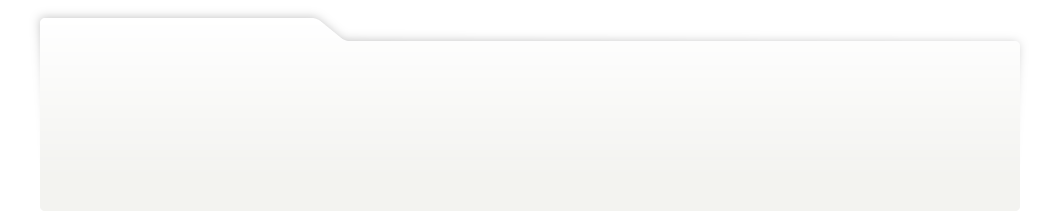
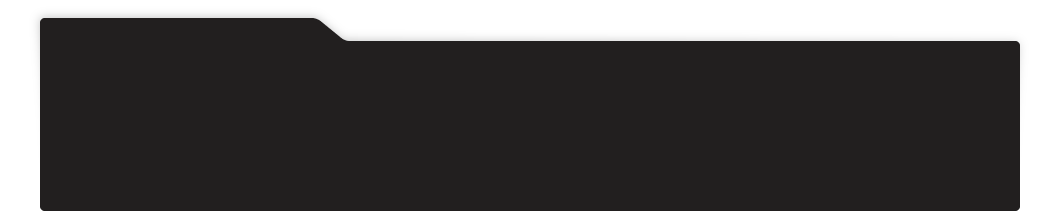
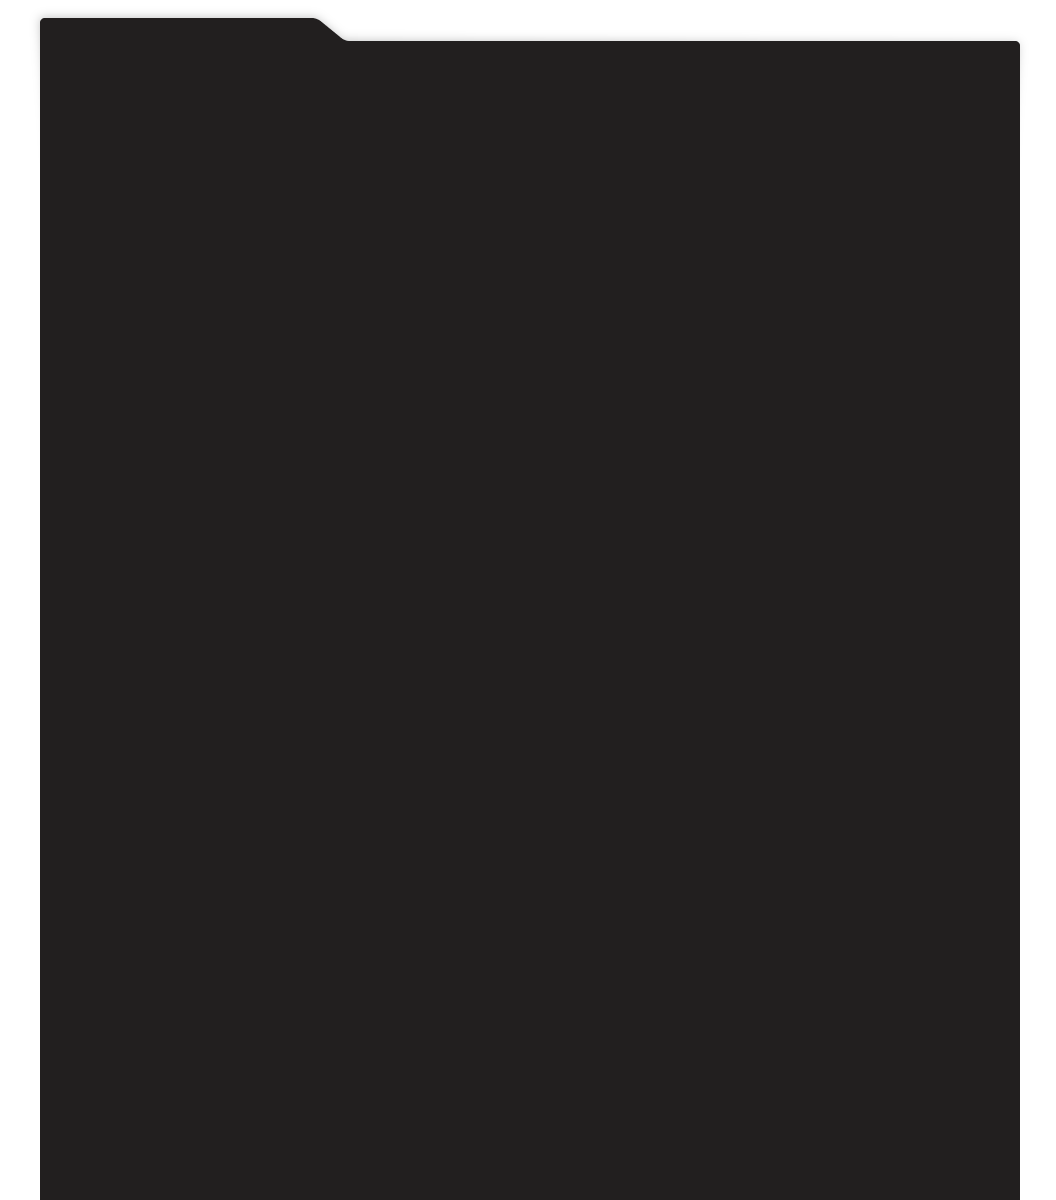
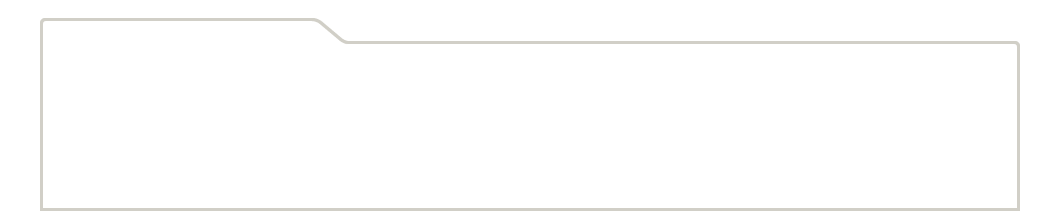
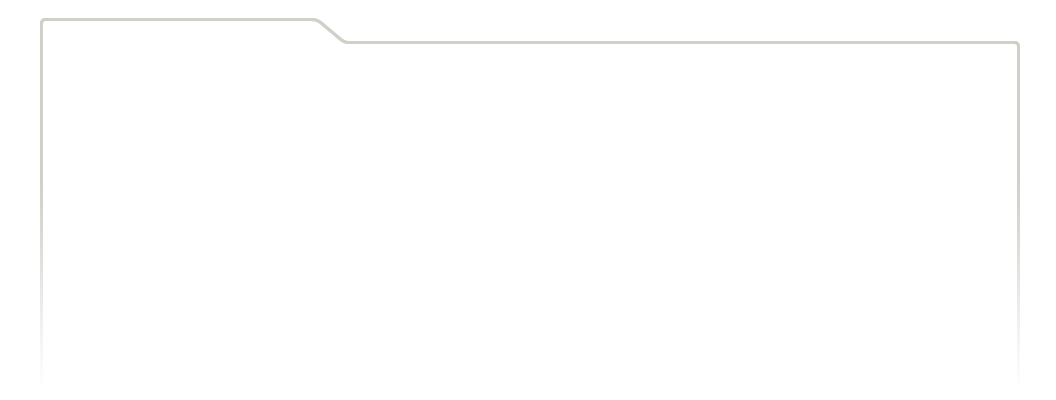
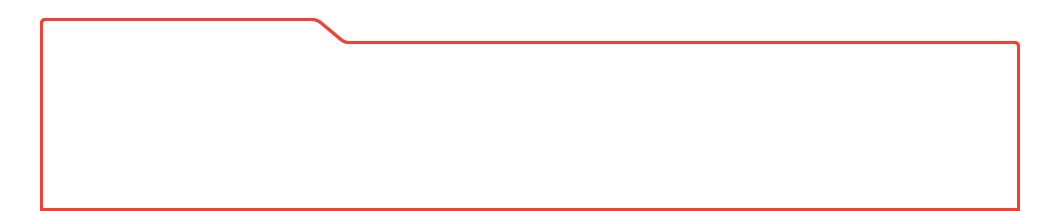
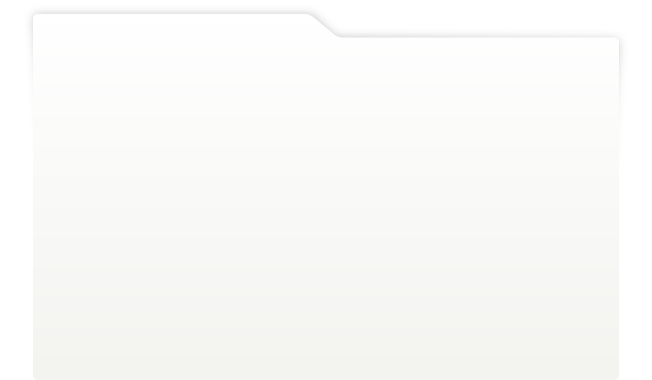
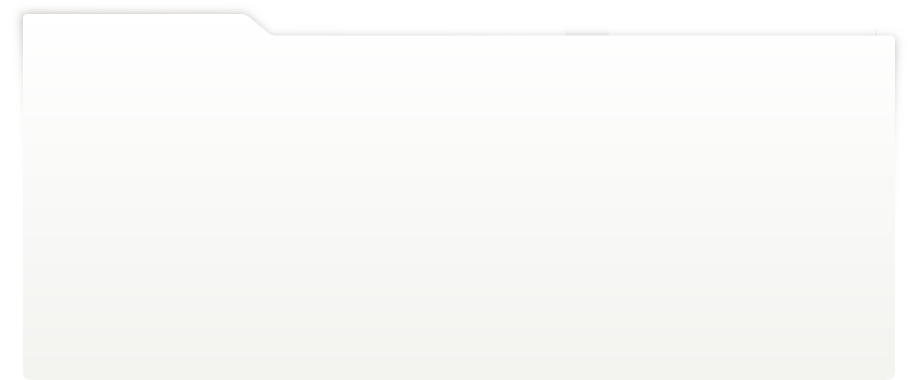
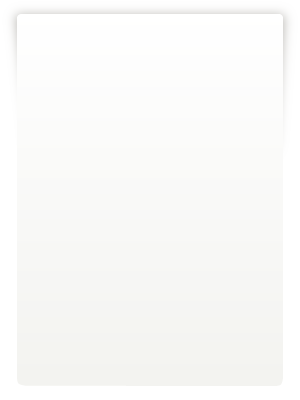
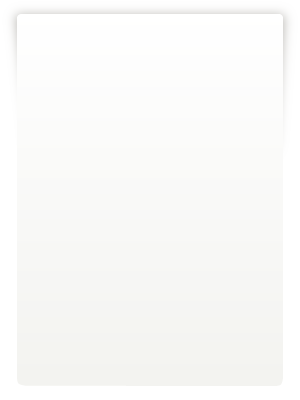
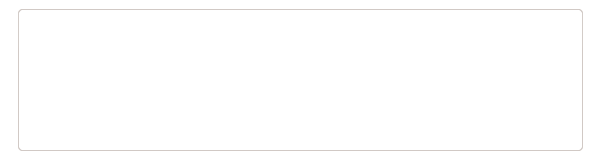
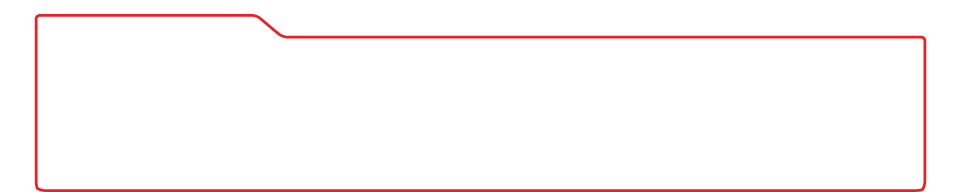
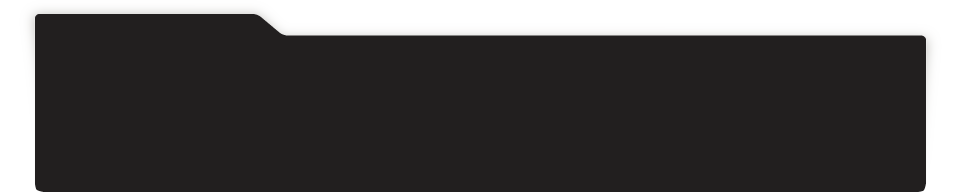
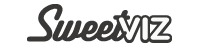
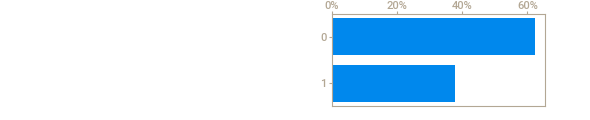
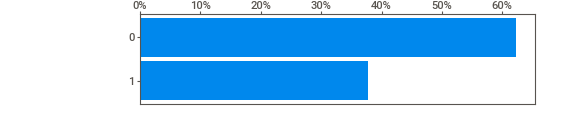
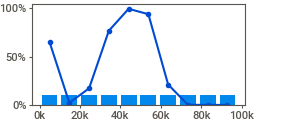
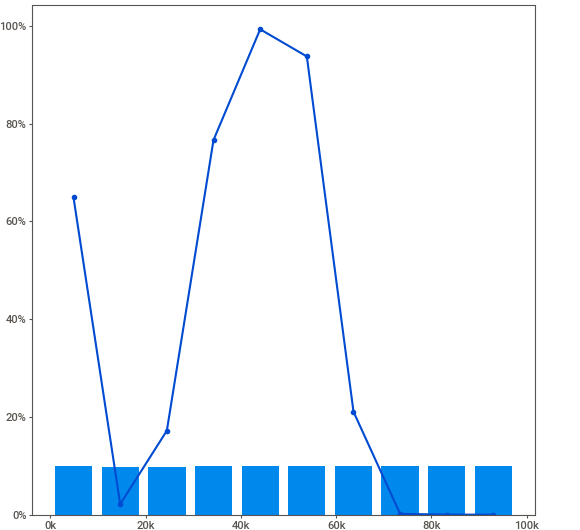
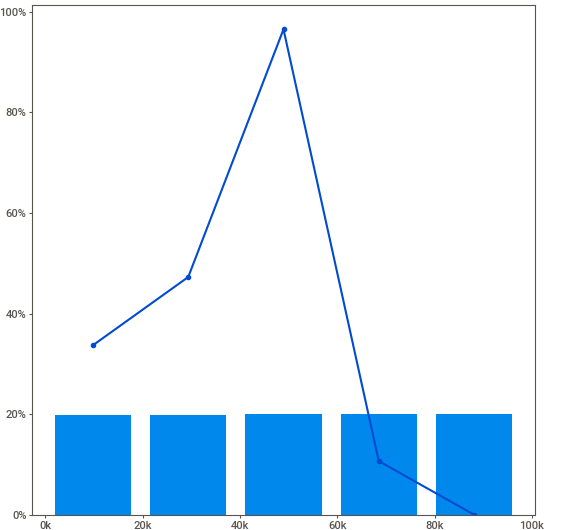
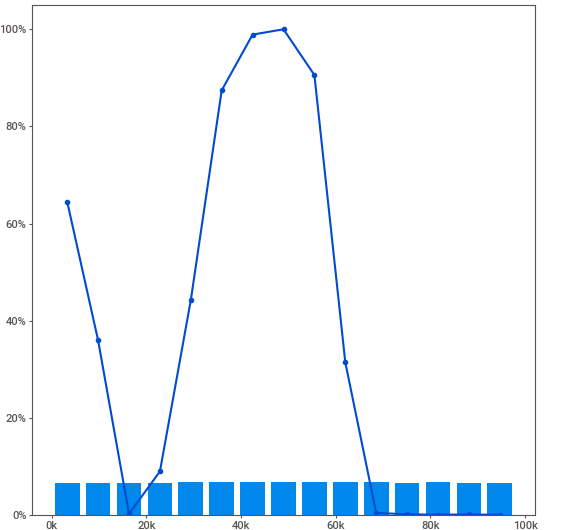
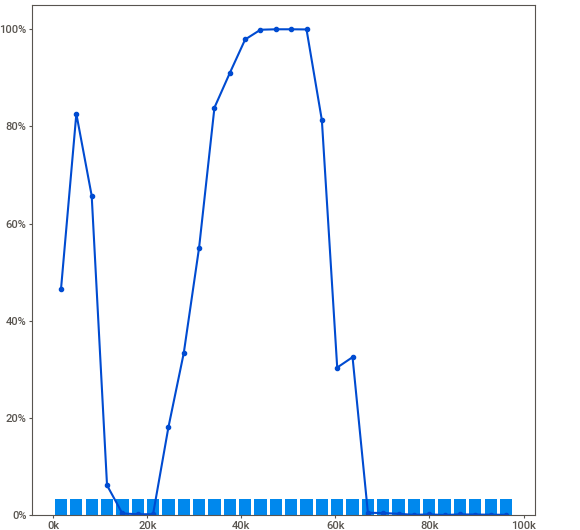
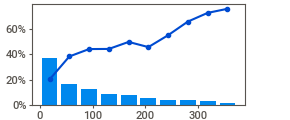
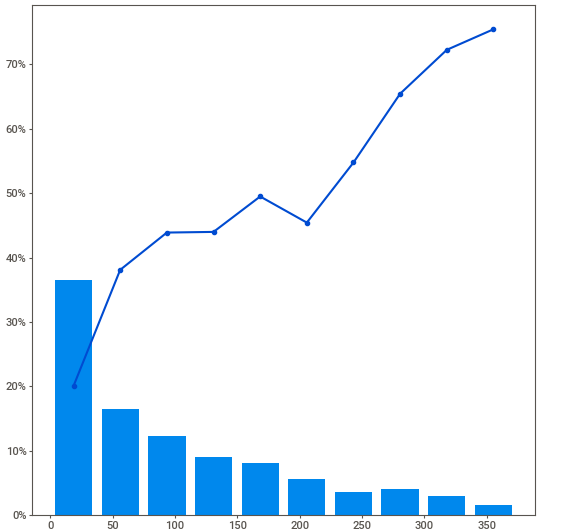
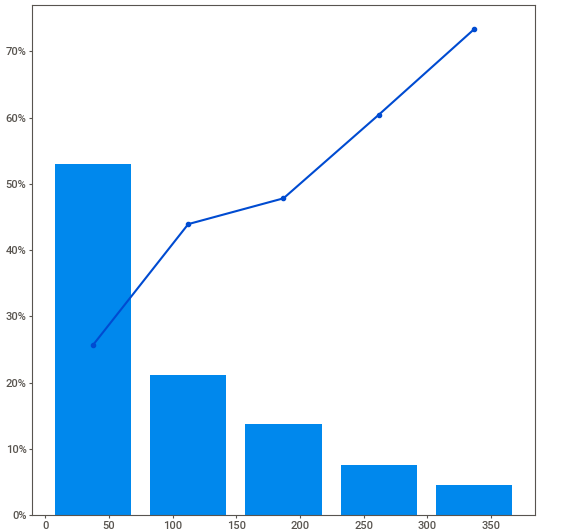
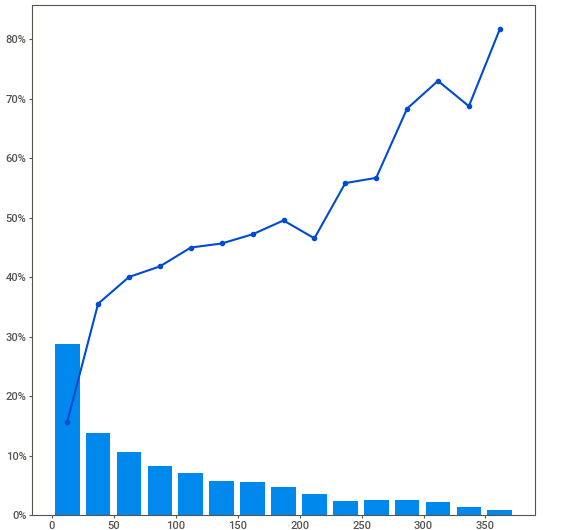
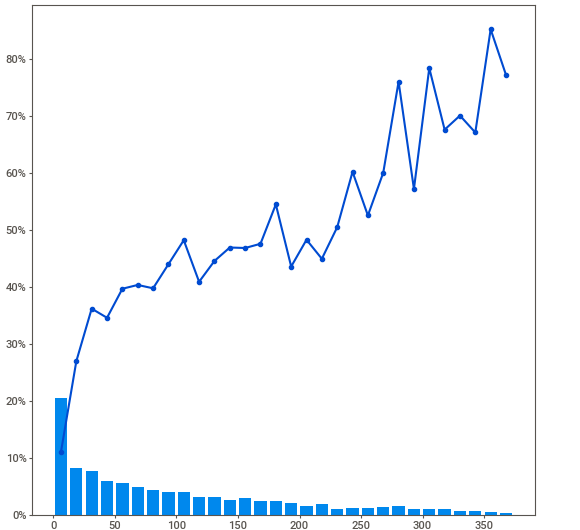
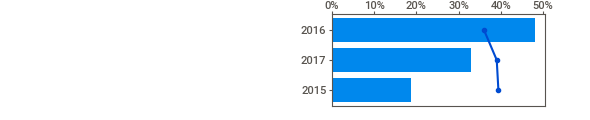
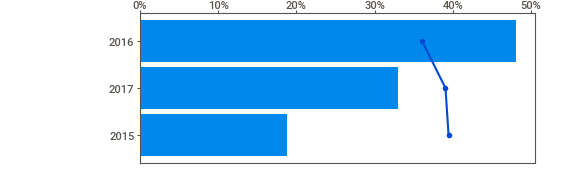
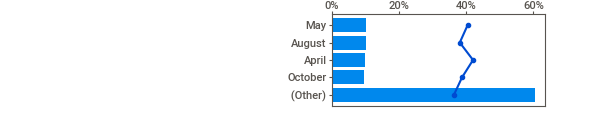
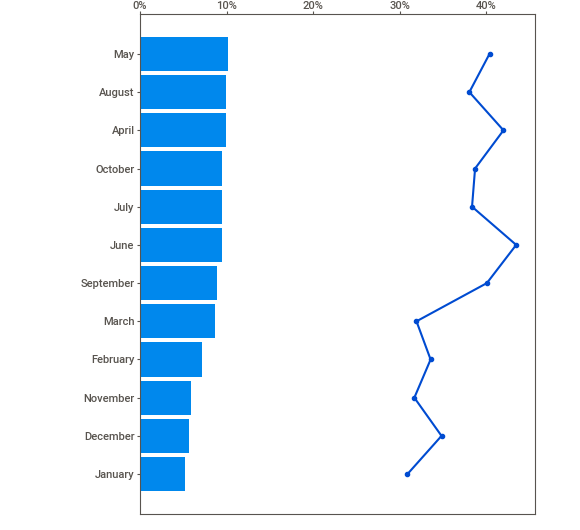
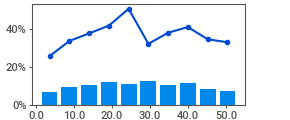
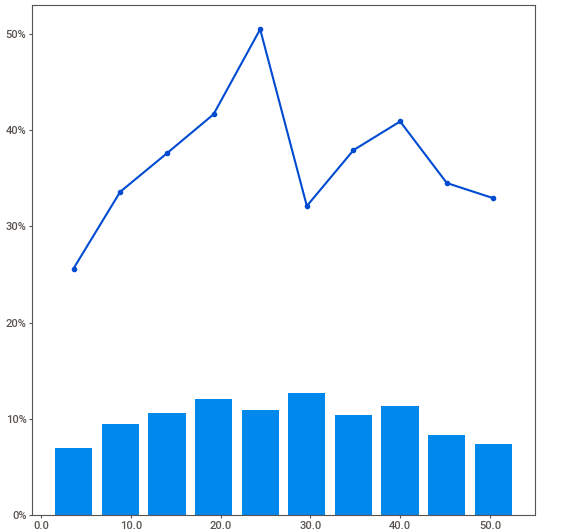
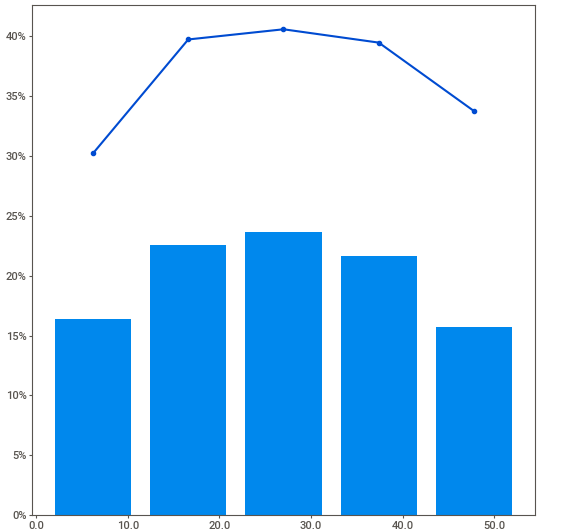
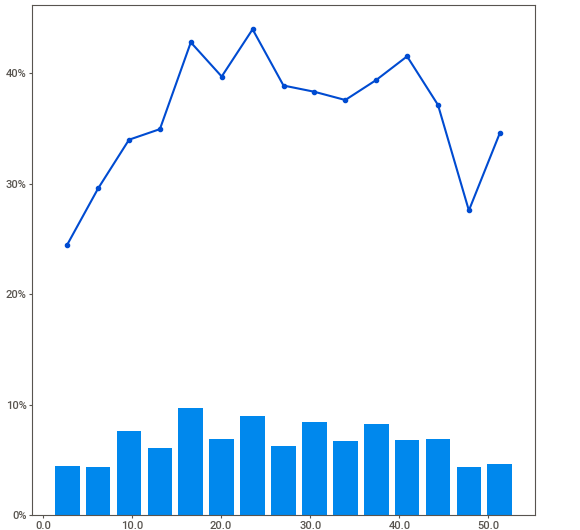
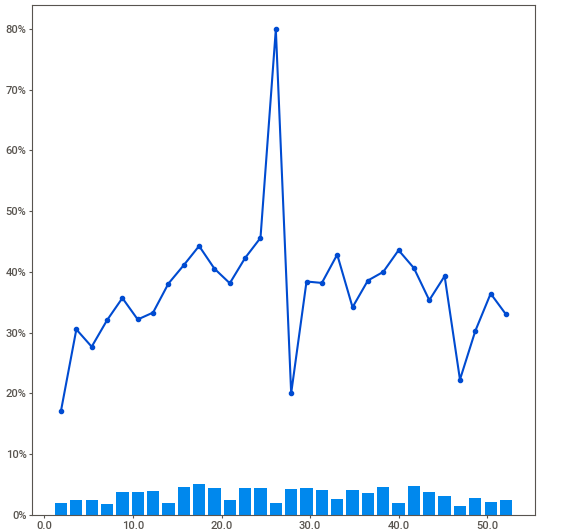
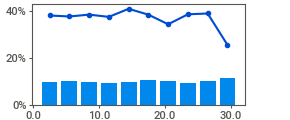
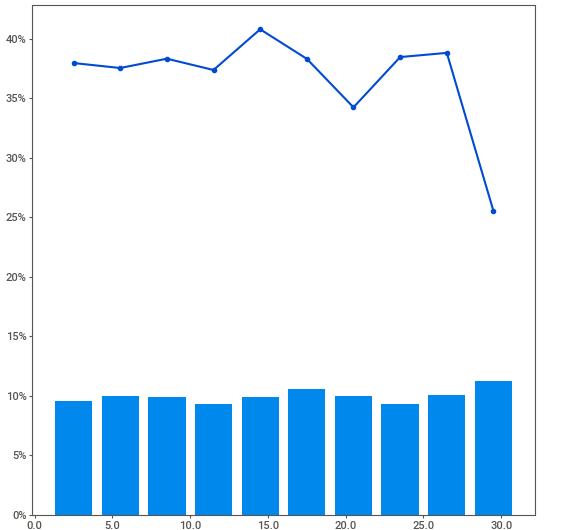
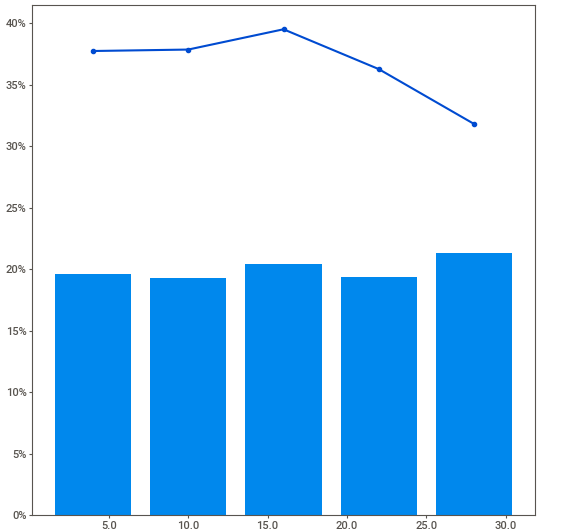
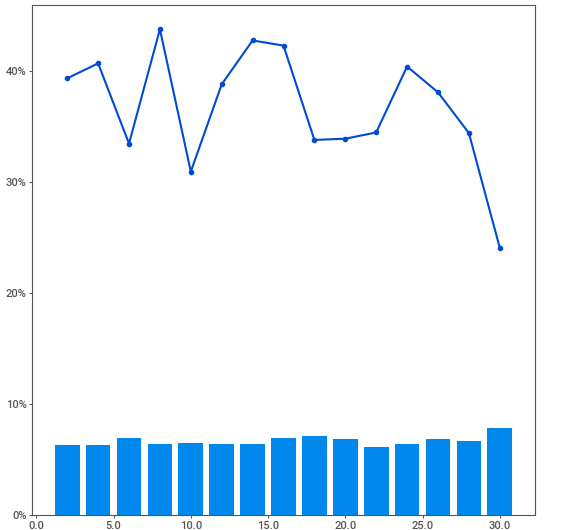
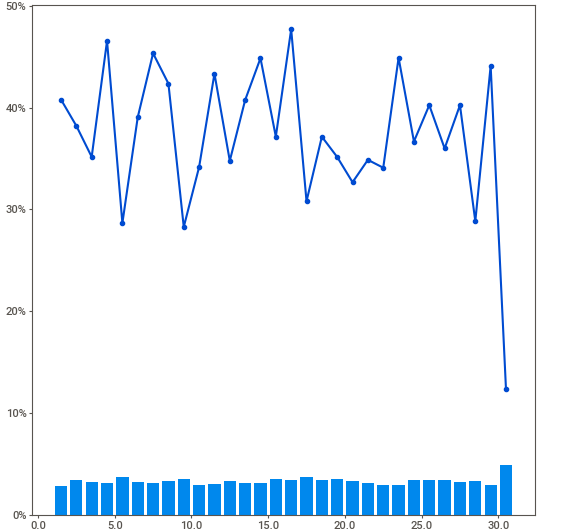
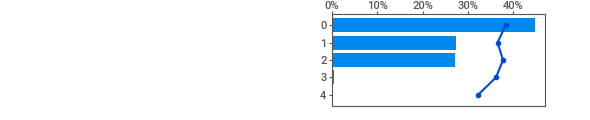
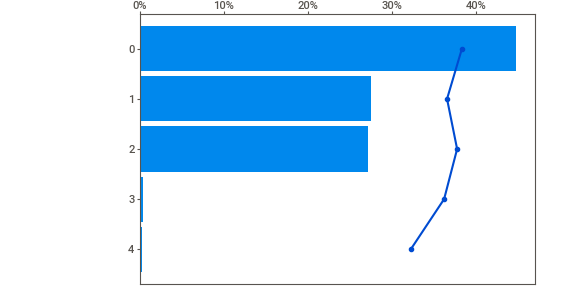
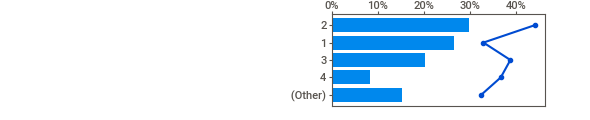
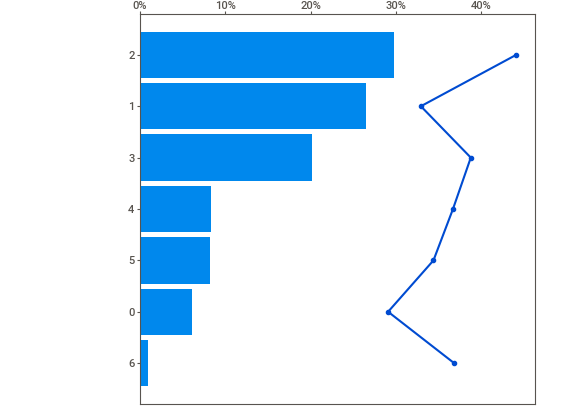
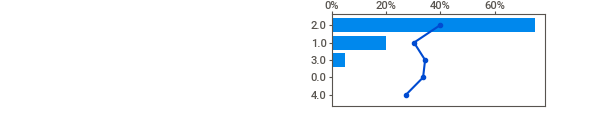
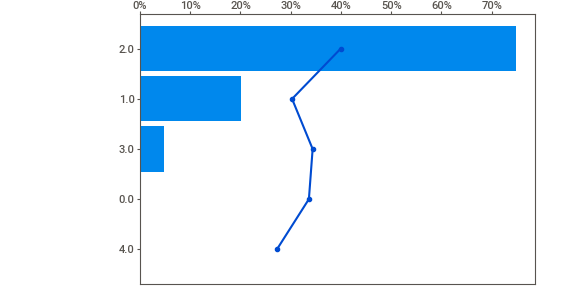
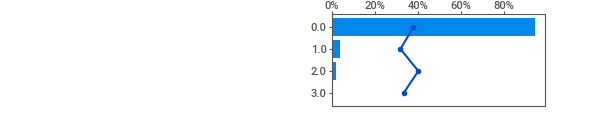
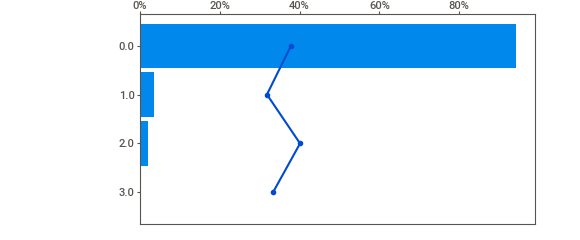
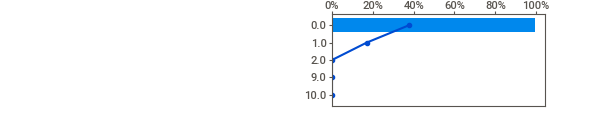
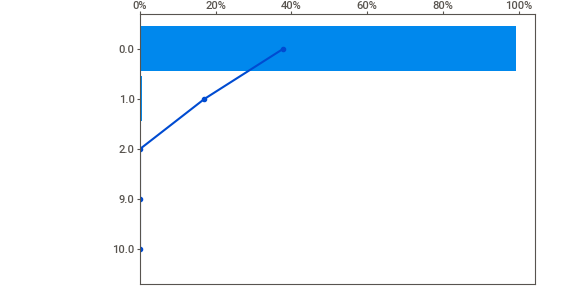
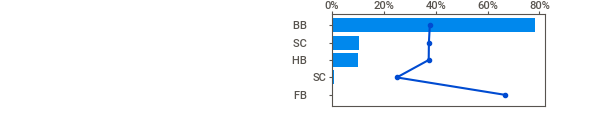
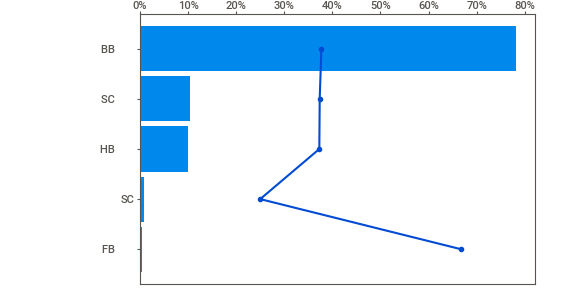
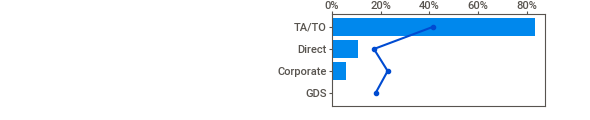
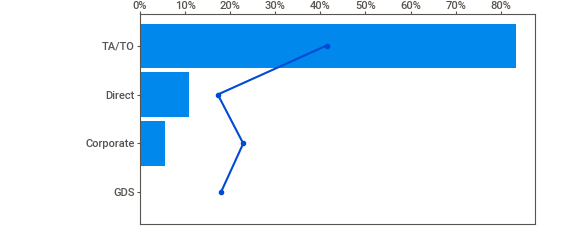
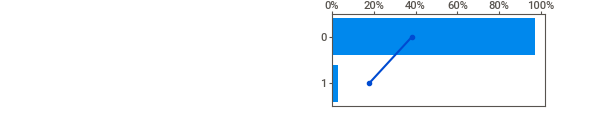
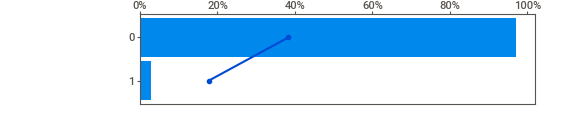
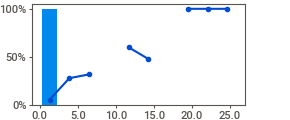
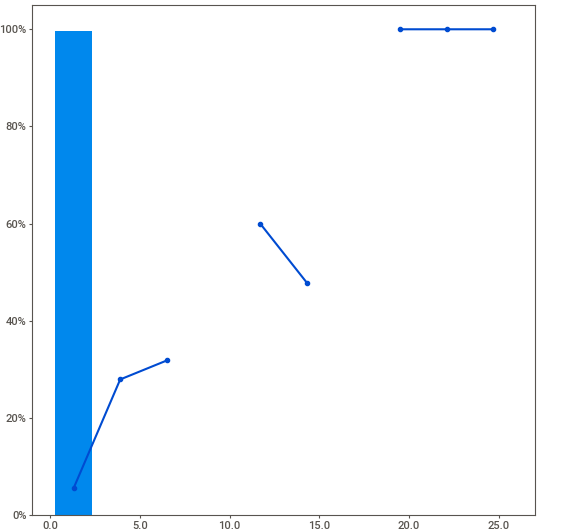
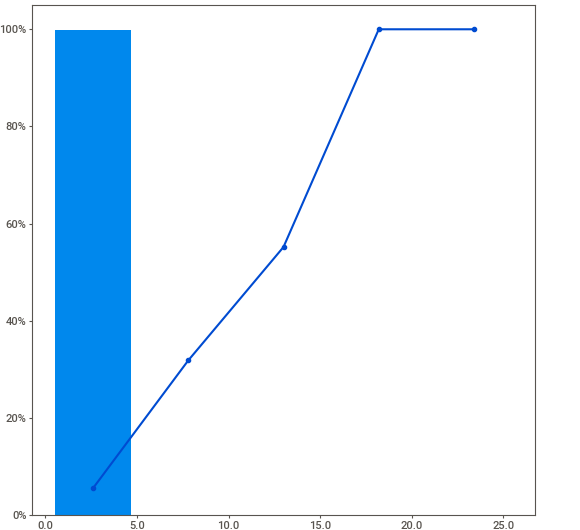
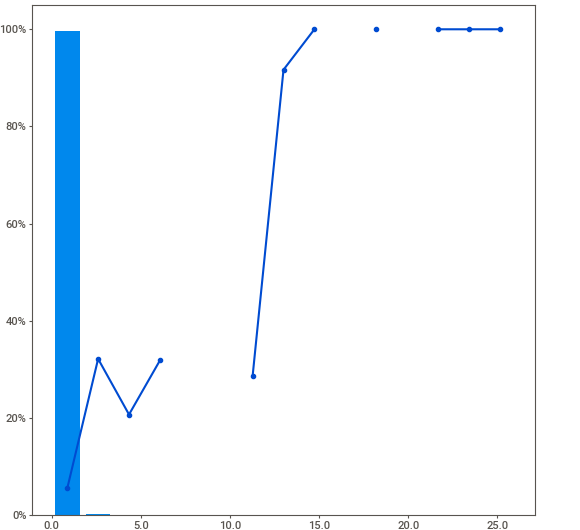
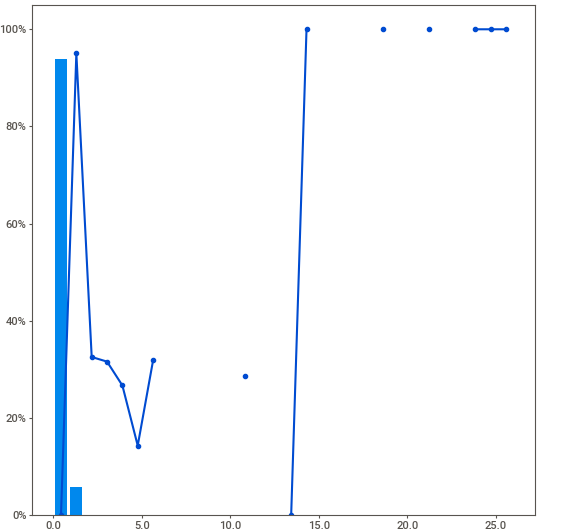
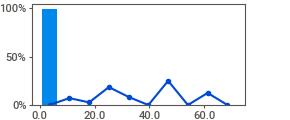
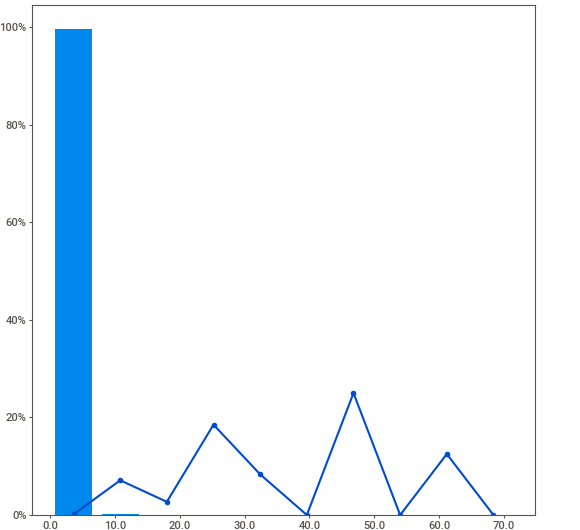
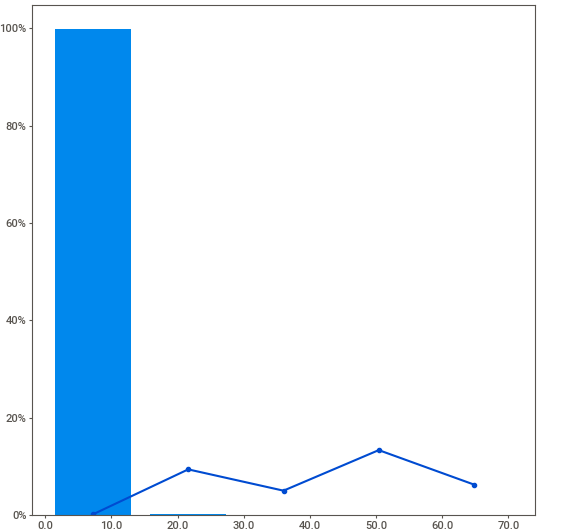
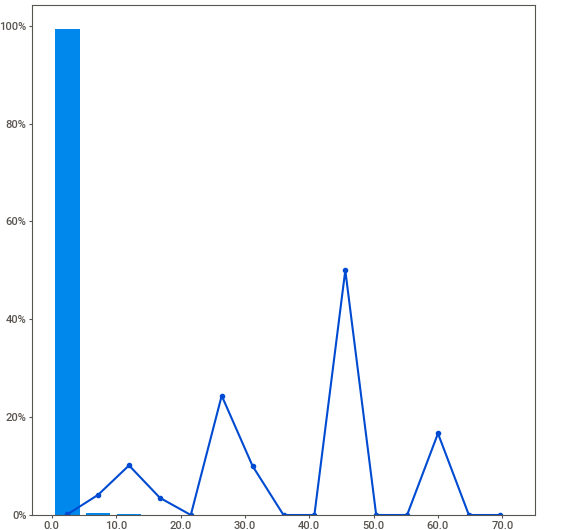
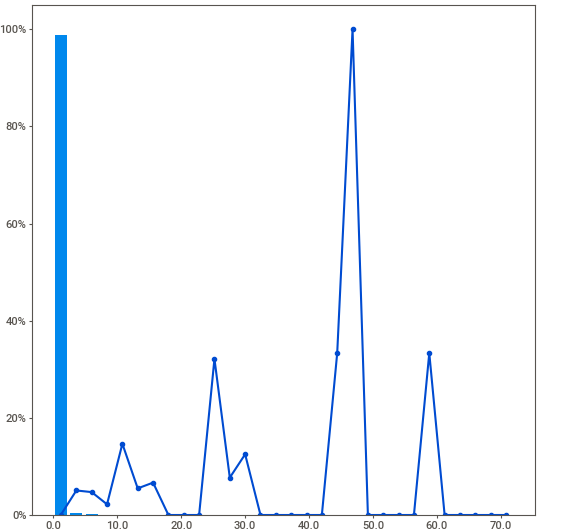
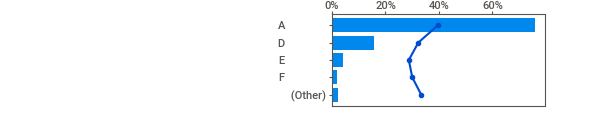
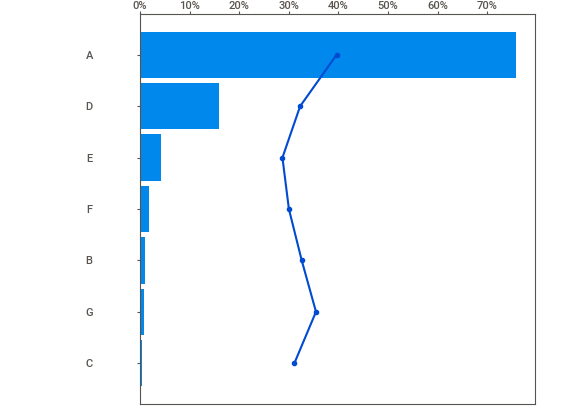
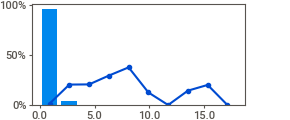
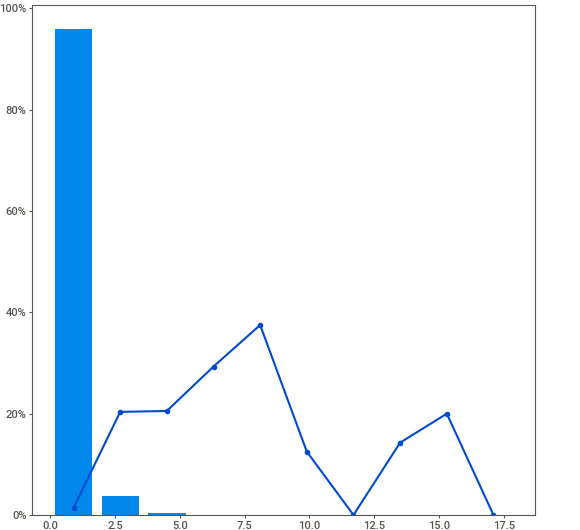
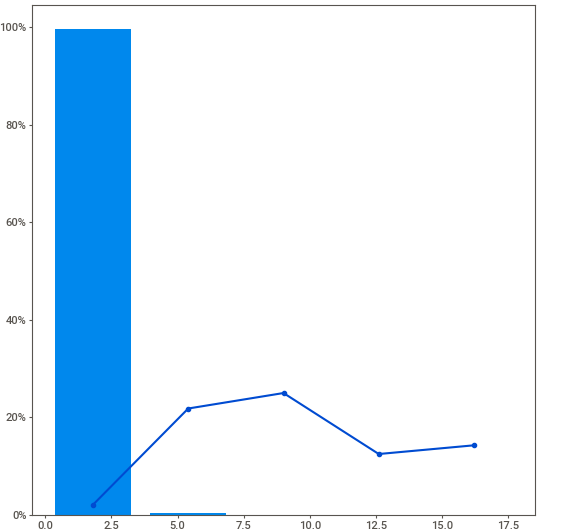
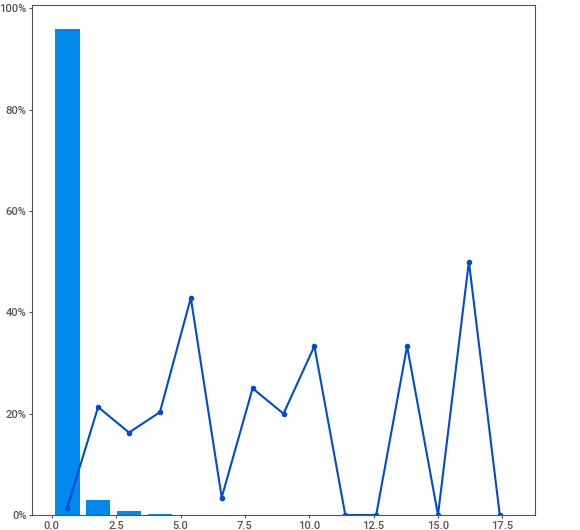
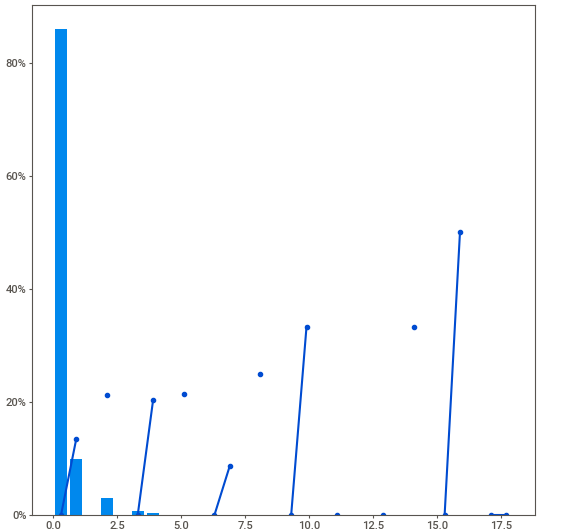
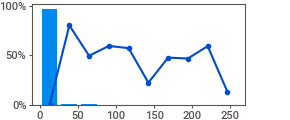
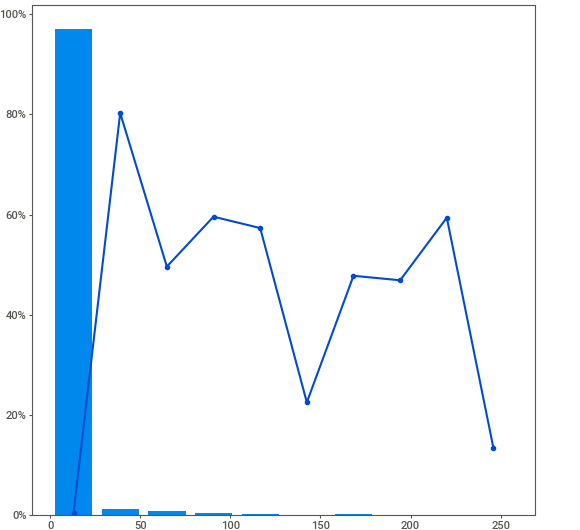
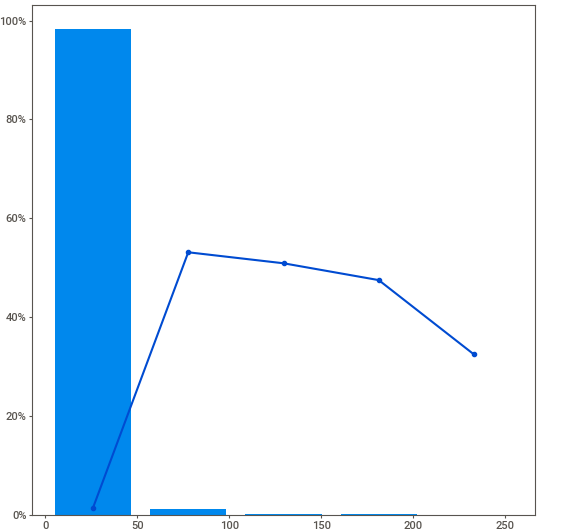
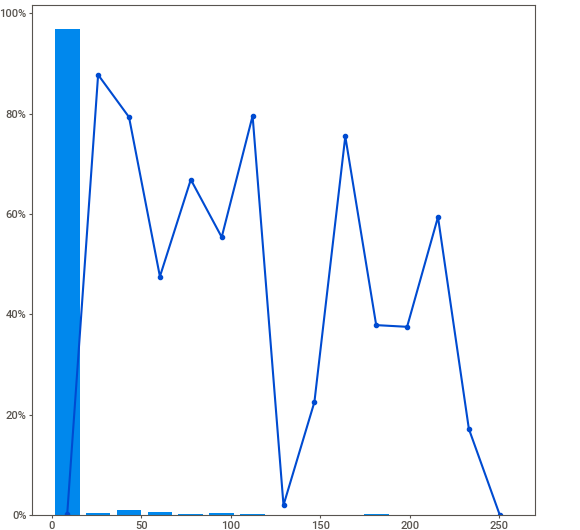
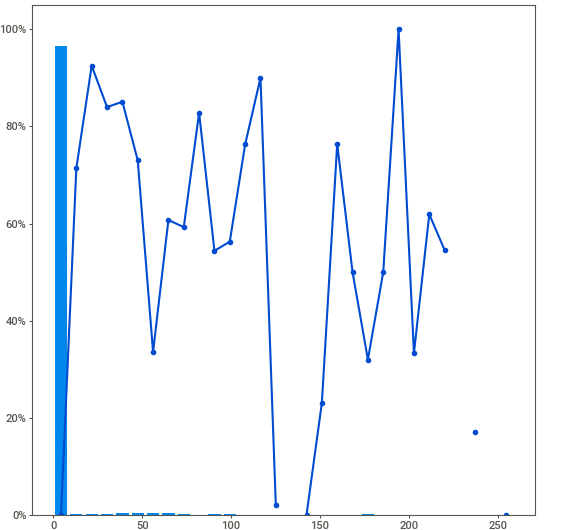
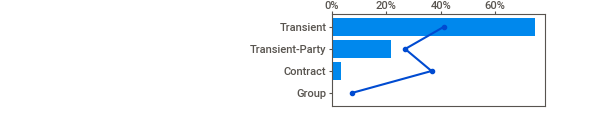
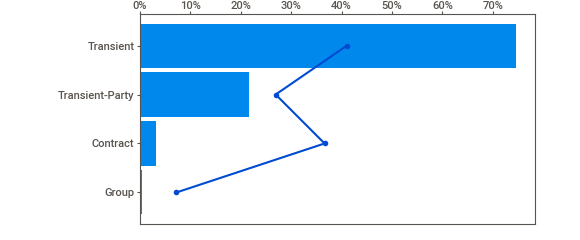
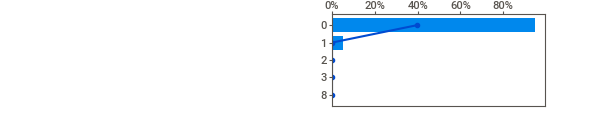
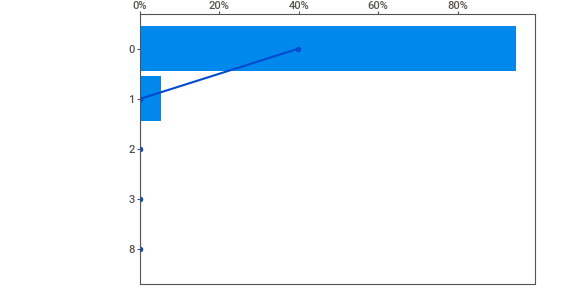
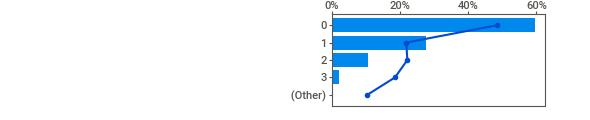
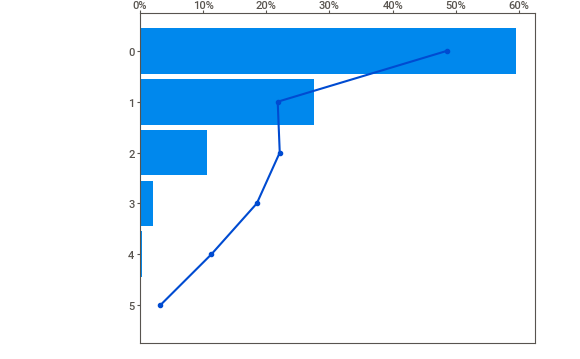
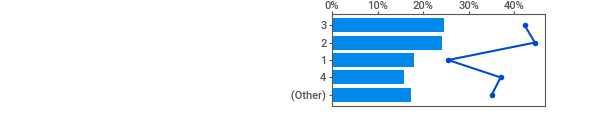
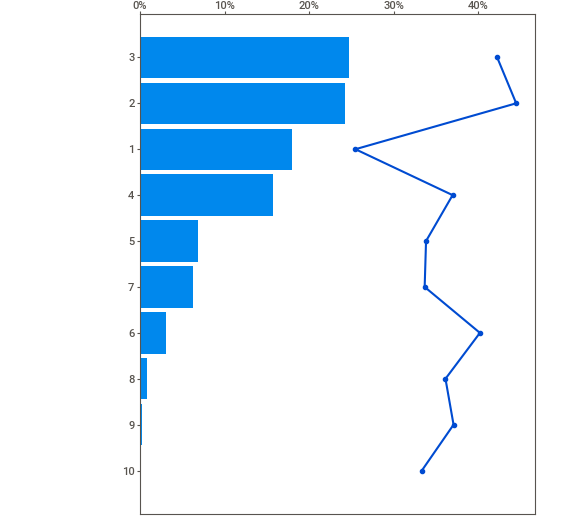
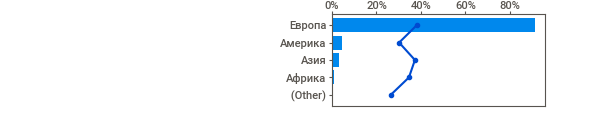
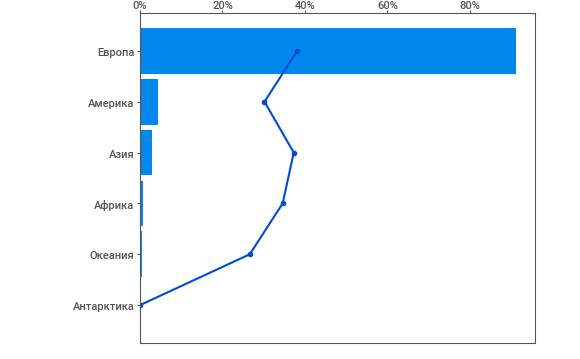
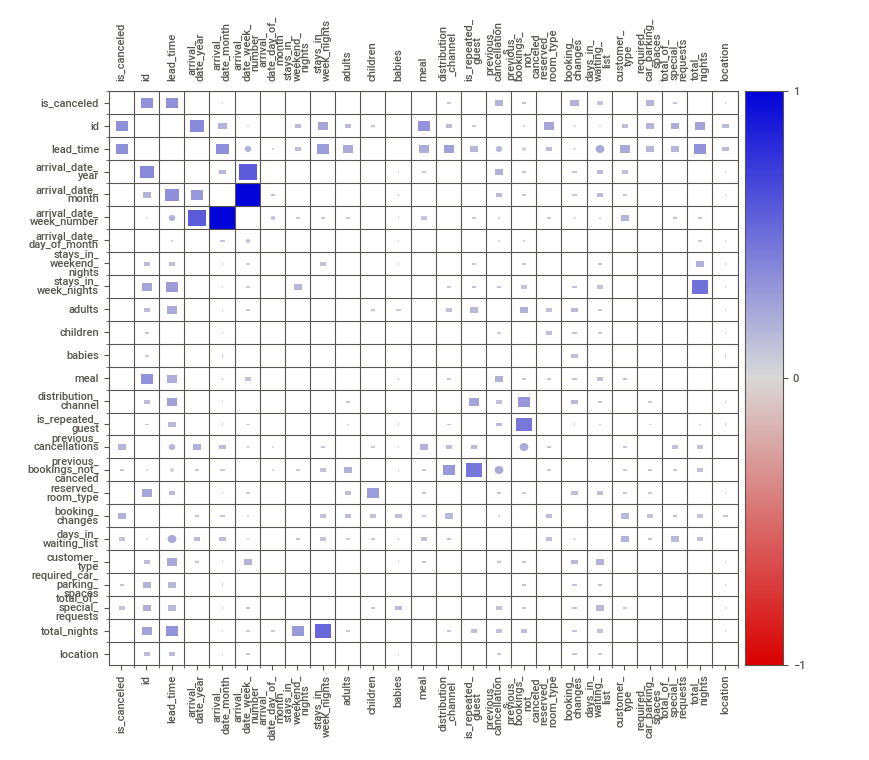
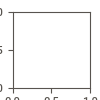

In [ ]:
report = sv.analyze([df, 'Target: is_canceled'], target_feat='is_canceled')
report.show_notebook(w=None, h=None, scale=0.9, layout='widescreen', filepath=None)

Пропуски и дубликаты обнаружены не были. Выявлены следующие аномалии: данные с количеством отмененных заказов больше 6 (возможно, баловство или боты), количество младенцев равное 9 и 10, избавимся от них в каждом датафрейме.

In [ ]:
df = df.query('previous_cancellations <= 6 & babies < 9')
df_train = df_train.query('previous_cancellations <= 6 & babies < 9')
df_test = df_test.query('previous_cancellations <= 6 & babies < 9')

Проверим колонку `id` на предмет возможных дубликатов. Остальные колонки могут иметь повторяющиеся значения, поэтому их не проверяем.

In [ ]:
df['id'].duplicated().sum()

0

In [ ]:
df['id'].nunique()

96538

Бронирований с двумя и более детьми, с двумя и более младенцами, с необходимостью более одного парковочного места слишком мало, чтобы использовать их для прогноза, приравняем такие записи к 1. И переименуем соответствующим образом названия колонок.

In [ ]:
df['children'] = df['children'].apply(lambda x: 1 if x >= 1 else 0)
df_train['children'] = df_train['children'].apply(lambda x: 1 if x >= 1 else 0)
df_test['children'] = df_test['children'].apply(lambda x: 1 if x >= 1 else 0)

df['babies'] = df['babies'].apply(lambda x: 1 if x >= 1 else 0)
df_train['babies'] = df_train['babies'].apply(lambda x: 1 if x >= 1 else 0)
df_test['babies'] = df_test['babies'].apply(lambda x: 1 if x >= 1 else 0)

df['required_car_parking_spaces'] = df['required_car_parking_spaces'].apply(lambda x: 1 if x >= 1 else 0)
df_train['required_car_parking_spaces'] = df_train['required_car_parking_spaces'].apply(lambda x: 1 if x >= 1 else 0)
df_test['required_car_parking_spaces'] = df_test['required_car_parking_spaces'].apply(lambda x: 1 if x >= 1 else 0)

In [ ]:
df = df.rename(columns={'children':'has_children', 'babies':'has_babies', 'required_car_parking_spaces':'need_car_parking_space'})
df_train = df_train.rename(columns={'children':'has_children', 'babies':'has_babies', 'required_car_parking_spaces':'need_car_parking_space'})
df_test = df_test.rename(columns={'children':'has_children', 'babies':'has_babies', 'required_car_parking_spaces':'need_car_parking_space'})

Детям до 14 лет и младенцам номер сдать не могут, поэтому удалим все строки, где количество взрослых равно нулю.

In [ ]:
df = df.query('adults > 0')
df_train = df_train.query('adults > 0')
df_test = df_test.query('adults > 0')

Проверим все категориальные признаки на предмет наличия лишних символов в их названиях и возможности образования дубликатов.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96303 entries, 0 to 96680
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              96303 non-null  int64  
 1   is_canceled                     96303 non-null  int64  
 2   lead_time                       96303 non-null  float64
 3   arrival_date_year               96303 non-null  int64  
 4   arrival_date_month              96303 non-null  object 
 5   arrival_date_week_number        96303 non-null  int64  
 6   arrival_date_day_of_month       96303 non-null  int64  
 7   stays_in_weekend_nights         96303 non-null  int64  
 8   stays_in_week_nights            96303 non-null  int64  
 9   adults                          96303 non-null  float64
 10  has_children                    96303 non-null  int64  
 11  has_babies                      96303 non-null  int64  
 12  meal                            

In [ ]:
df['arrival_date_month'].unique()

array(['July', 'August', 'September', 'October', 'November', 'December',
       'January', 'February', 'March', 'April', 'May', 'June'],
      dtype=object)

In [ ]:
df['meal'].unique()

array(['BB       ', 'HB       ', 'FB       ', 'SC', 'SC       '],
      dtype=object)

In [ ]:
df['country'].unique()

array(['GBR', 'PRT', 'ESP', 'IRL', 'FRA', 'ROU', 'NOR', 'USA', 'DEU',
       'BEL', 'CHE', 'GRC', 'NLD', 'ARG', 'RUS', 'SWE', 'POL', 'EST',
       'CZE', 'ITA', 'FIN', 'DNK', 'MOZ', 'BWA', 'LUX', 'BRA', 'SVN',
       'ALB', 'CHN', 'MEX', 'MAR', 'SMR', 'LVA', 'CHL', 'AUT', 'LTU',
       'TUR', 'ISR', 'IND', 'CYM', 'AUS', 'CPV', 'ZWE', 'DZA', 'KOR',
       'CRI', 'HUN', 'TUN', 'ARE', 'HRV', 'HKG', 'IRN', 'GIB', 'JEY',
       'URY', 'ZAF', 'COL', 'GGY', 'KWT', 'CYP', 'KAZ', 'THA', 'DOM',
       'NGA', 'BLR', 'VEN', 'UKR', 'ARM', 'JPN', 'LKA', 'MYS', 'BIH',
       'MUS', 'OMN', 'SUR', 'JAM', 'BGR', 'CIV', 'SRB', 'JOR', 'SYR',
       'PHL', 'PRI', 'SGP', 'BDI', 'LBN', 'AGO', 'VNM', 'AZE', 'PLW',
       'NZL', 'EGY', 'MDV', 'CMR', 'MLT', 'SVK', 'MWI', 'STP', 'TWN',
       'IDN', 'SEN', 'PER', 'SAU', 'KNA', 'ETH', 'ECU', 'IRQ', 'AND',
       'HND', 'PAK', 'GEO', 'ZMB', 'QAT', 'KHM', 'MCO', 'BGD', 'ISL',
       'UZB', 'IMN', 'TJK', 'NIC', 'BEN', 'MAC', 'VGB', 'TZA', 'GAB',
       'MKD', 'GLP',

In [ ]:
df['distribution_channel'].unique()

array(['Direct', 'TA/TO', 'Corporate', 'GDS'], dtype=object)

In [ ]:
df['reserved_room_type'].unique()

array(['A               ', 'G               ', 'D               ',
       'E               ', 'C               ', 'F               ',
       'B               '], dtype=object)

In [ ]:
df['customer_type'].unique()

array(['Transient', 'Contract', 'Transient-Party', 'Group'], dtype=object)

В строках с категориями номеров и типом питания присутствуют лишние пробелы, уберем их.

In [ ]:
df['reserved_room_type'] = df['reserved_room_type'].apply(lambda x: x.strip())
df_train['reserved_room_type'] = df_train['reserved_room_type'].apply(lambda x: x.strip())
df_test['reserved_room_type'] = df_test['reserved_room_type'].apply(lambda x: x.strip())

df['meal'] = df['meal'].apply(lambda x: x.strip())
df_train['meal'] = df_train['meal'].apply(lambda x: x.strip())
df_test['meal'] = df_test['meal'].apply(lambda x: x.strip())

Произведем исследовательский анализ данных после изменения датафрейма.

                                             |          | [  0%]   00:00 -> (? left)


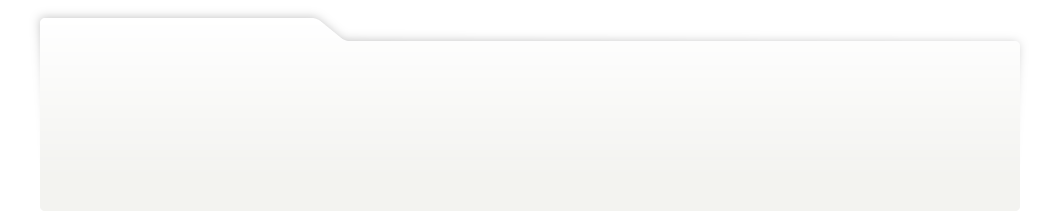
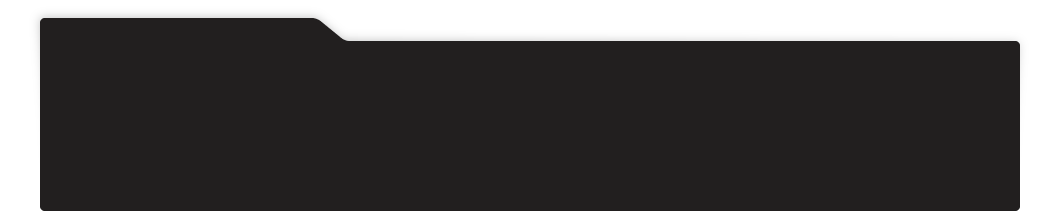
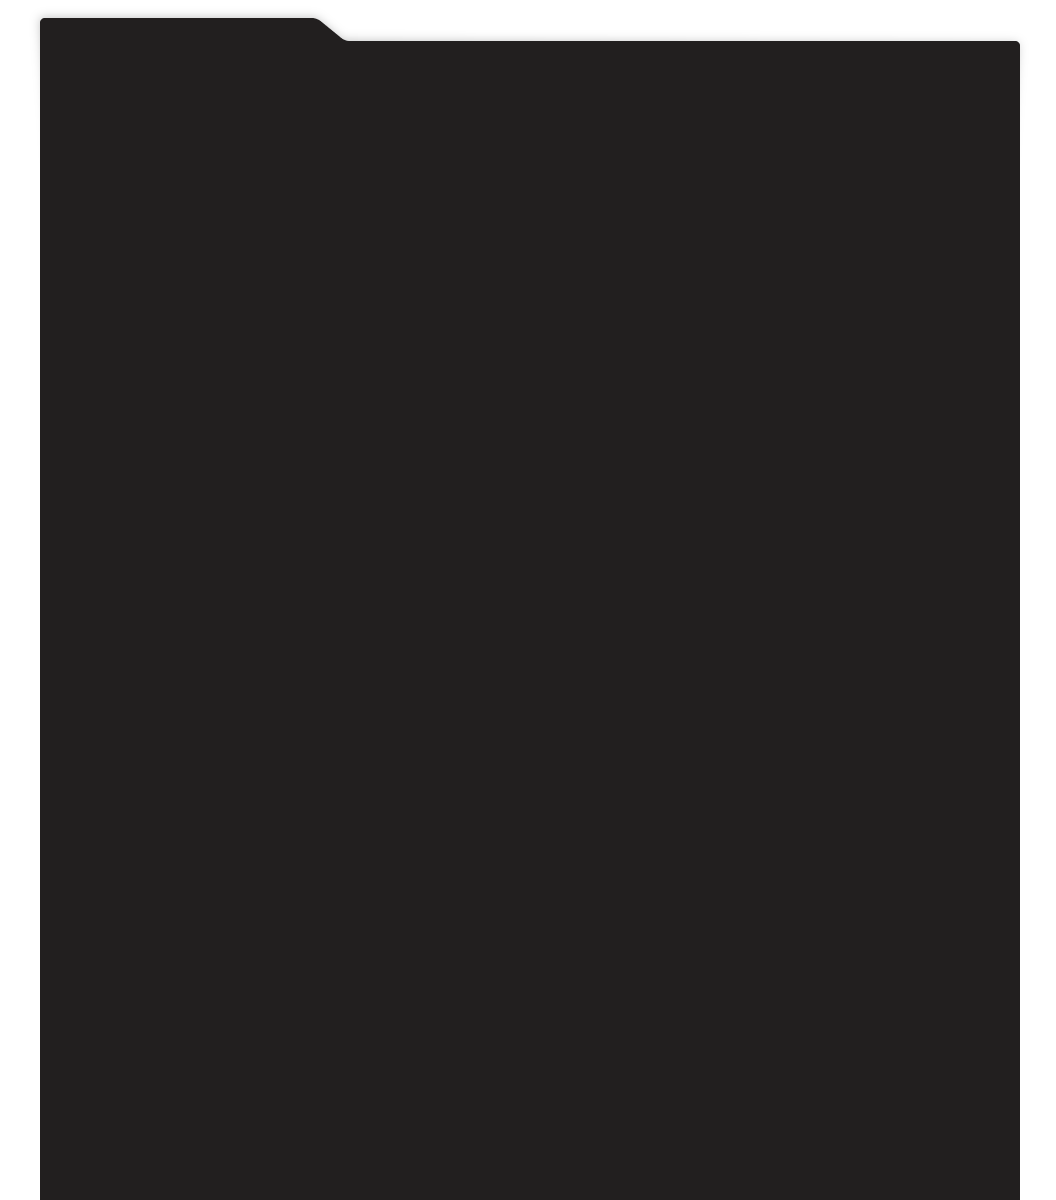
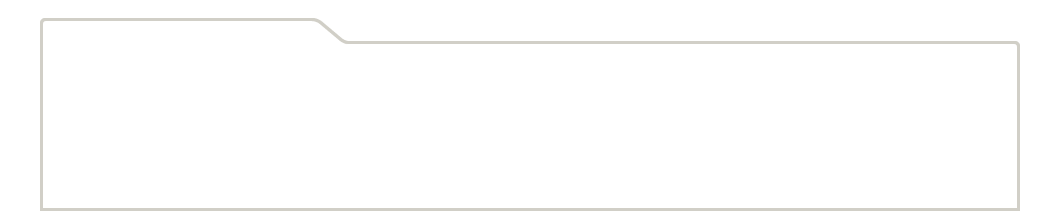
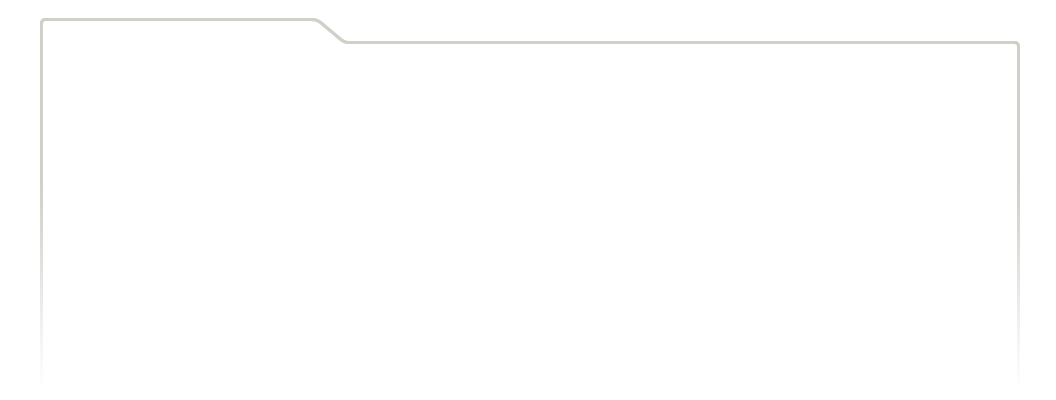
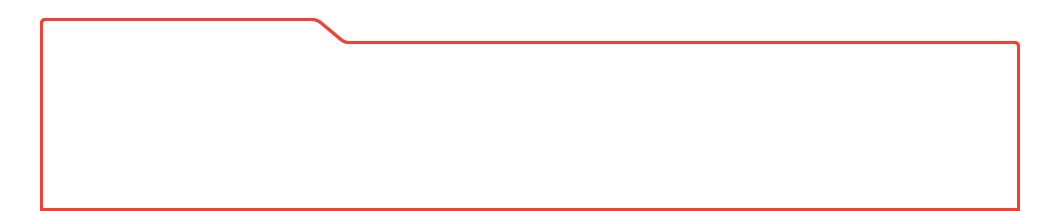
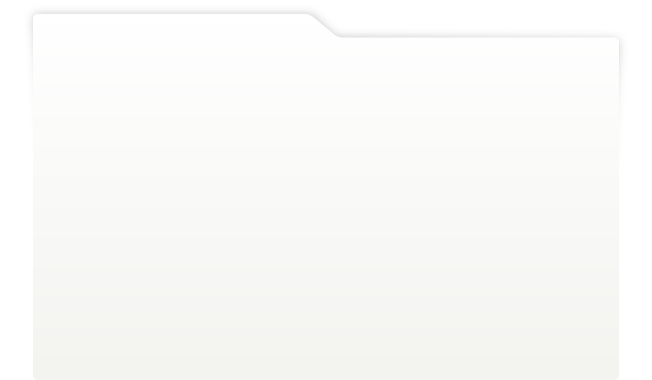
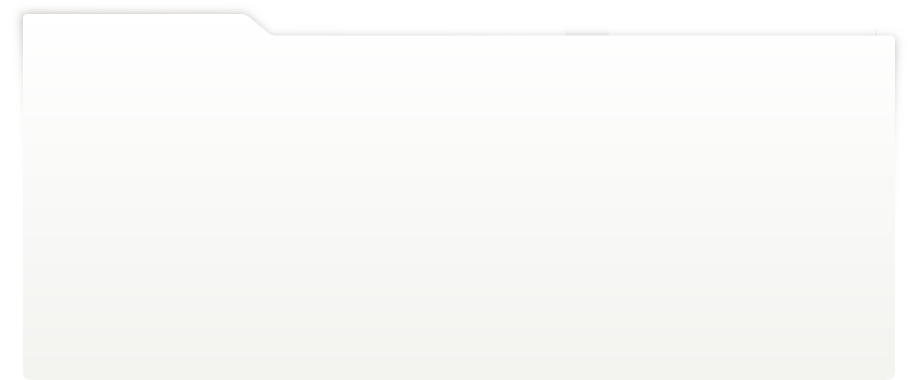
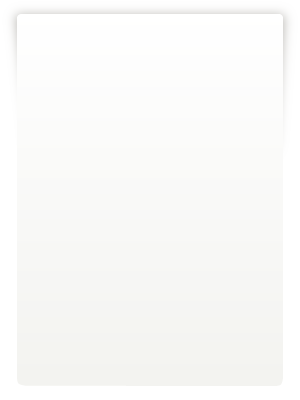
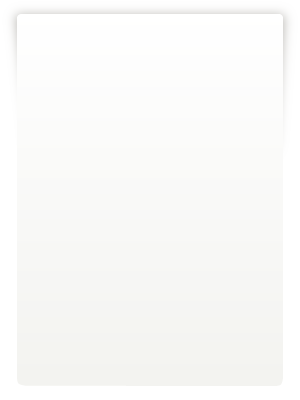
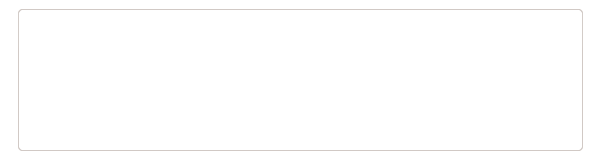
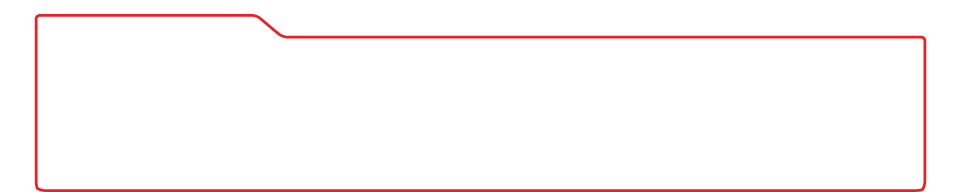
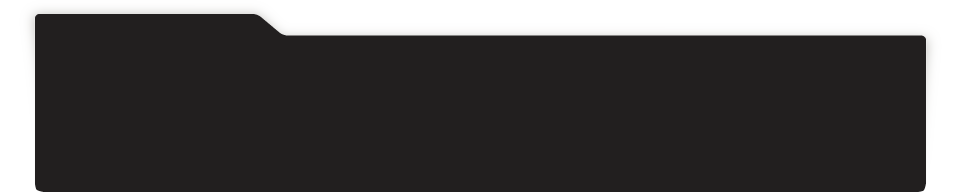
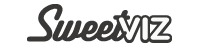
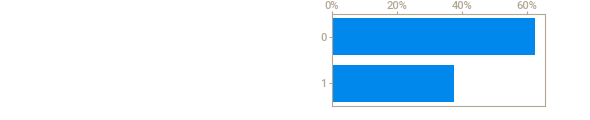
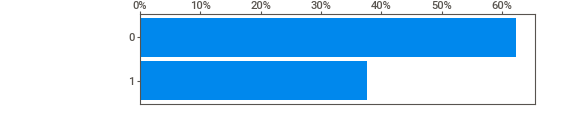
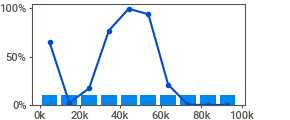
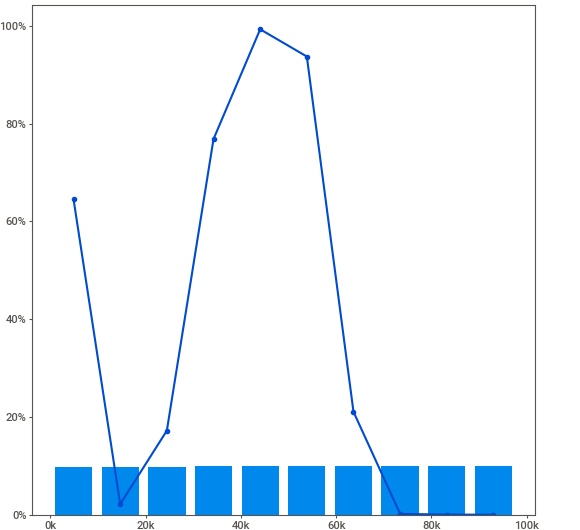
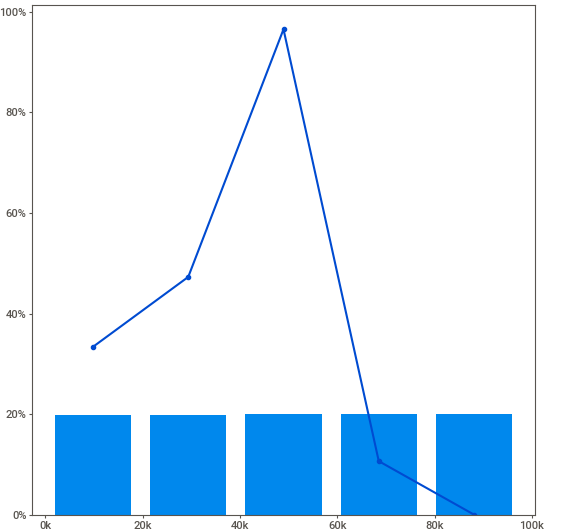
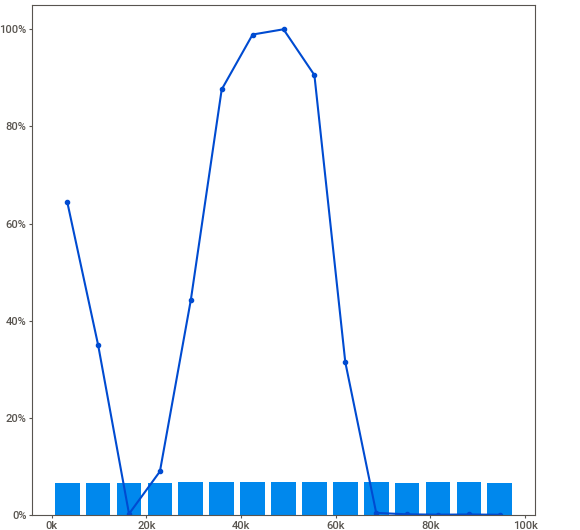
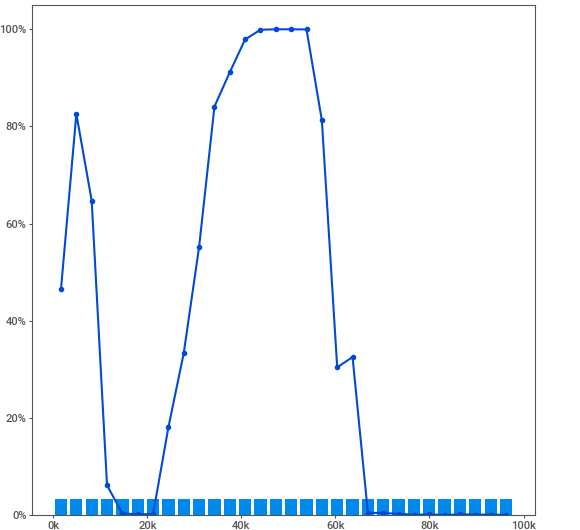
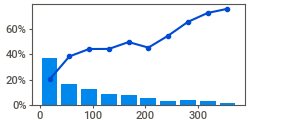
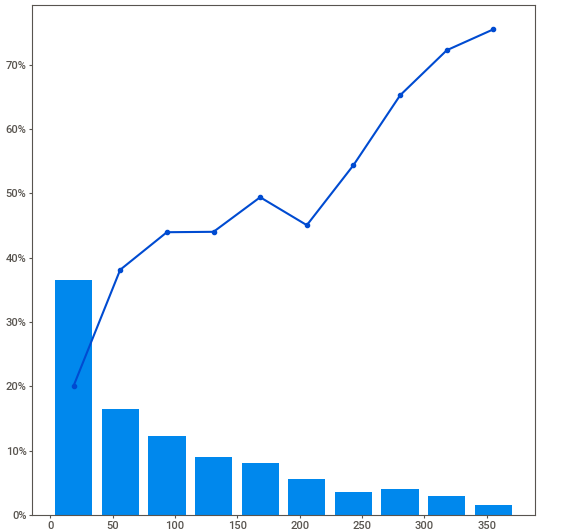
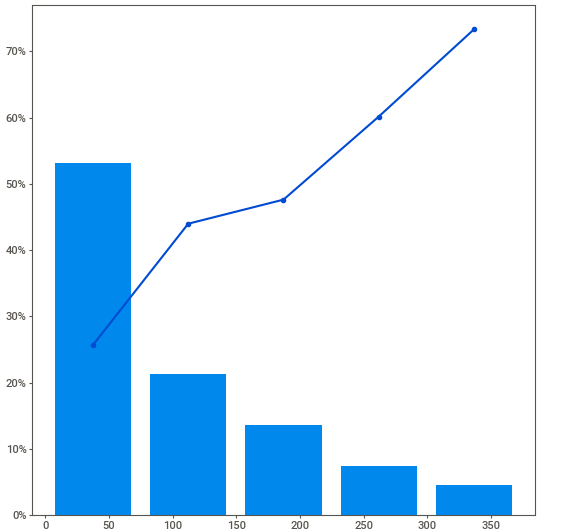
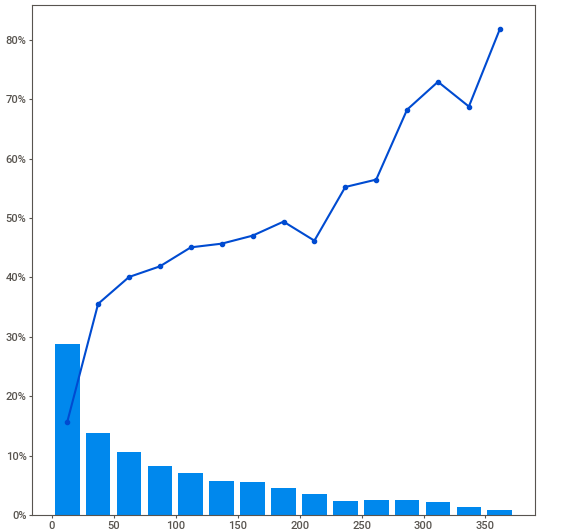
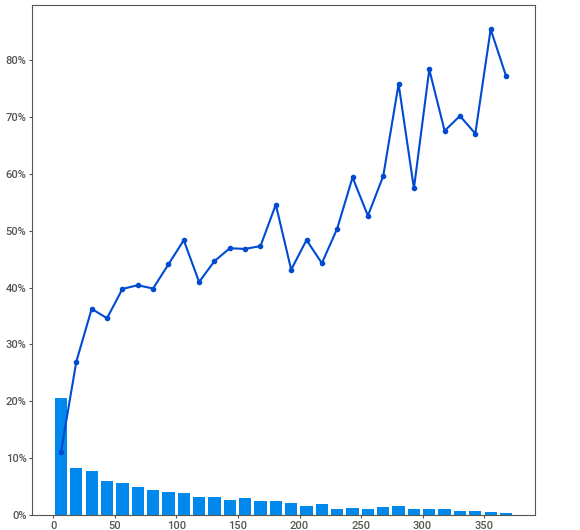
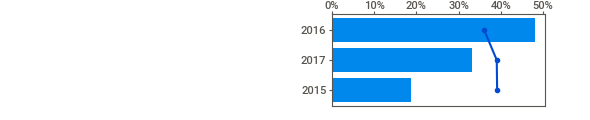
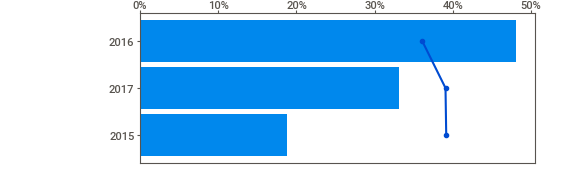
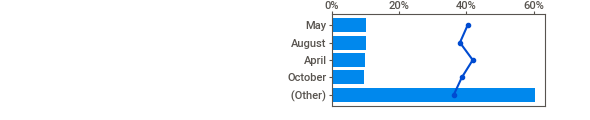
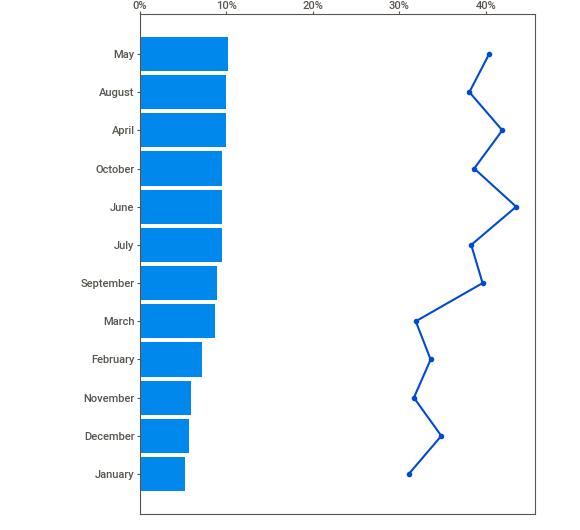
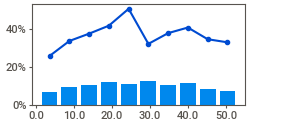
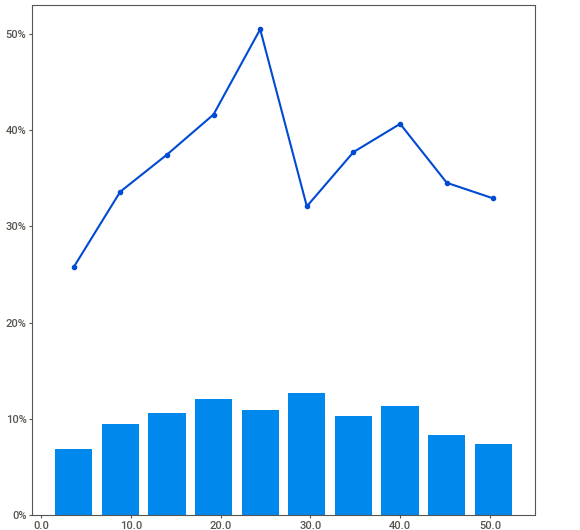
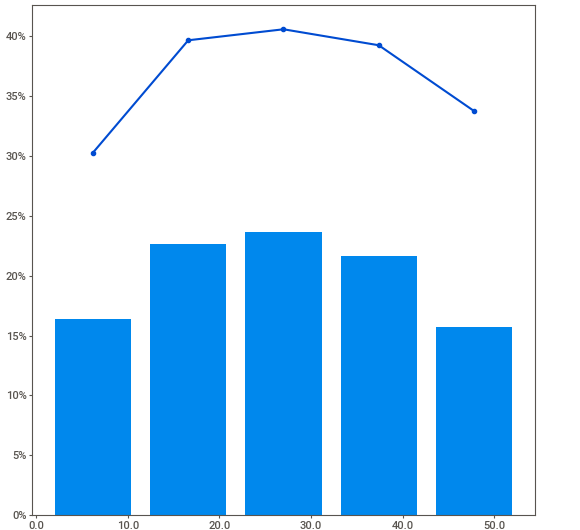
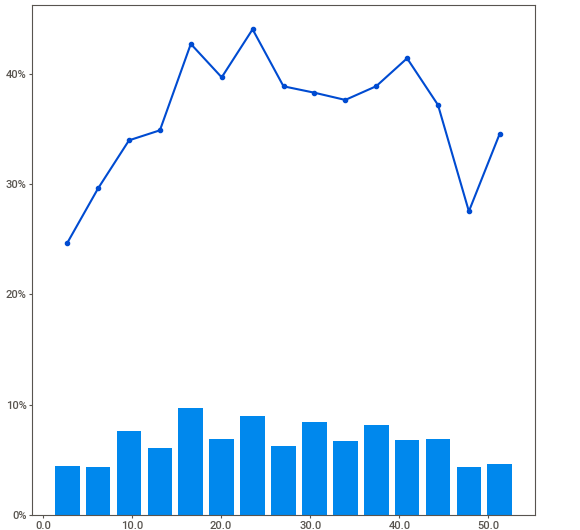
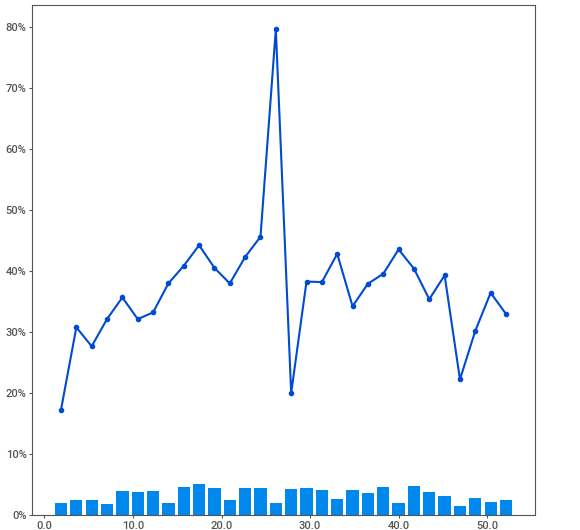
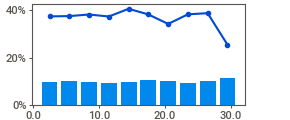
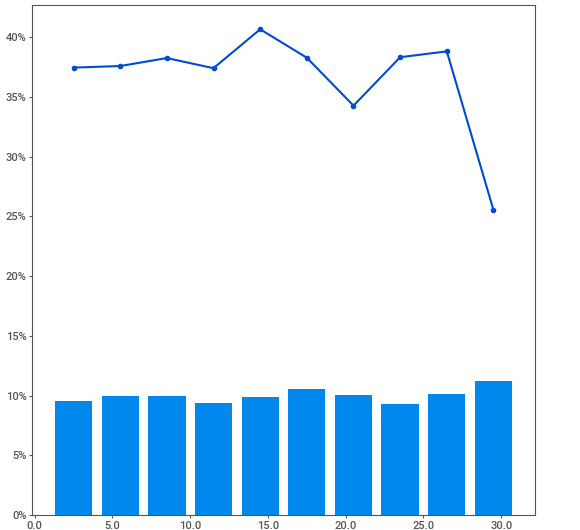
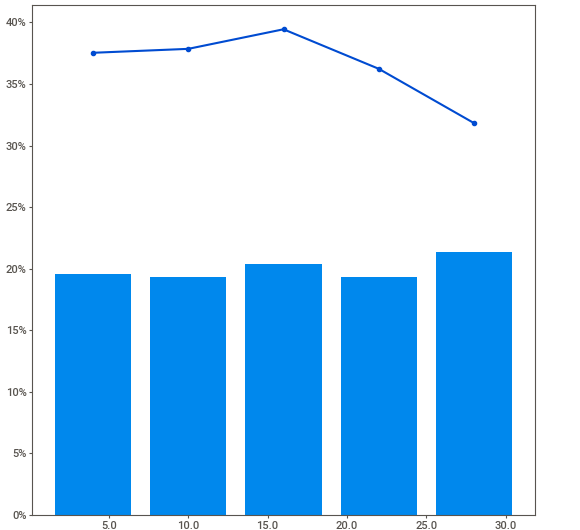
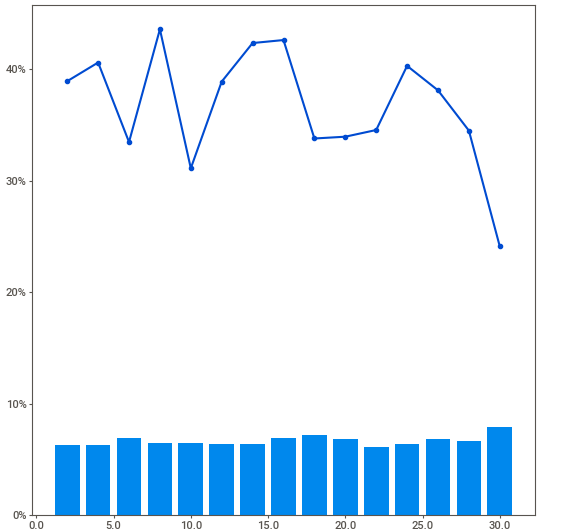
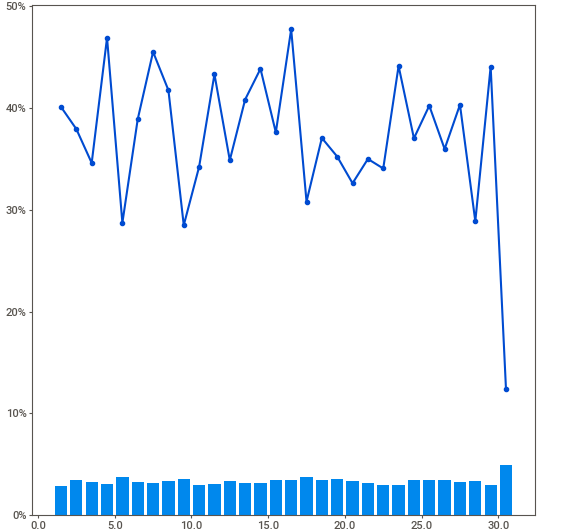
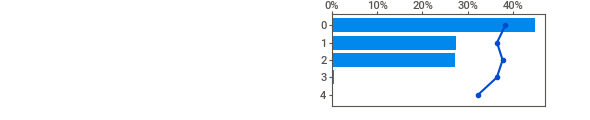
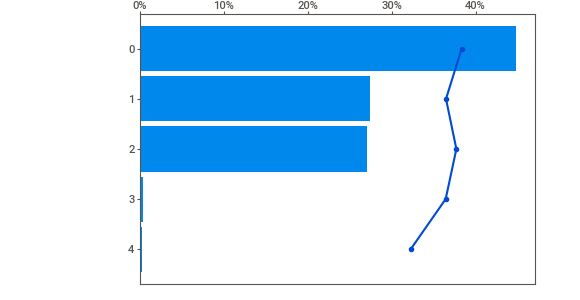
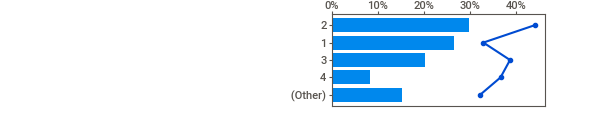
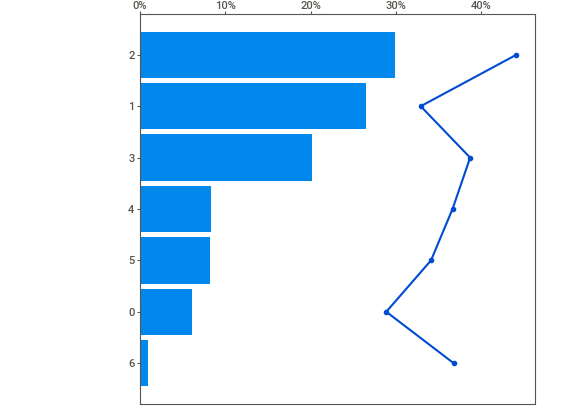
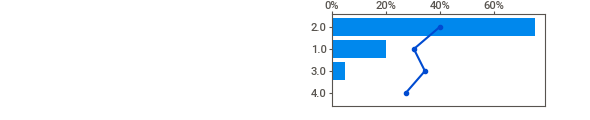
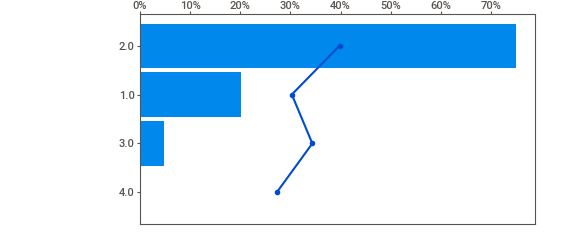
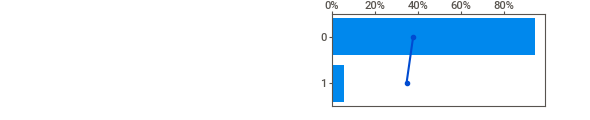
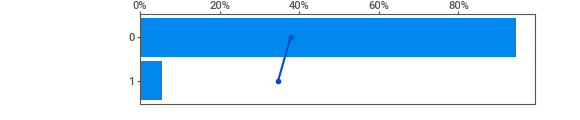
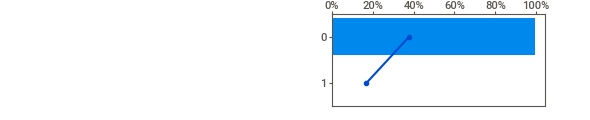
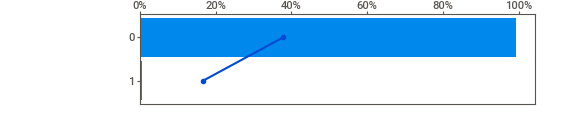
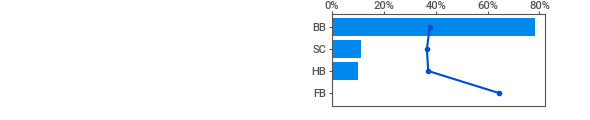
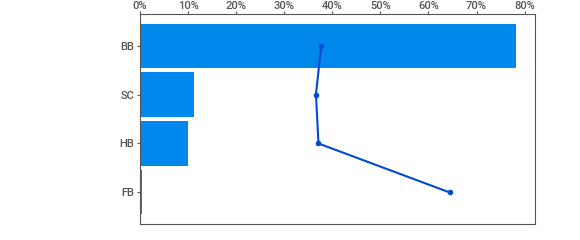
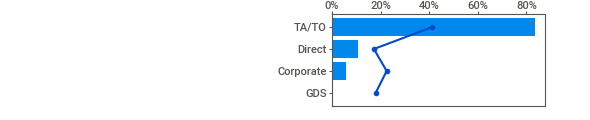
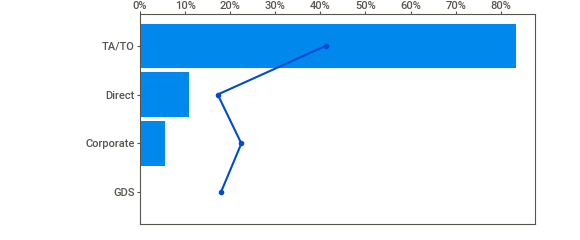
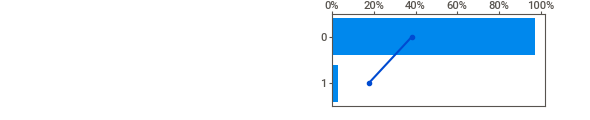
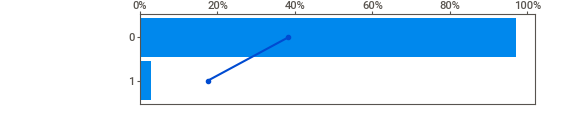
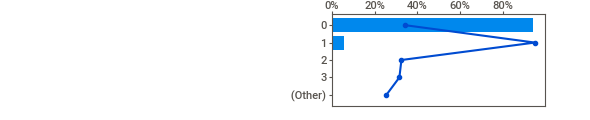
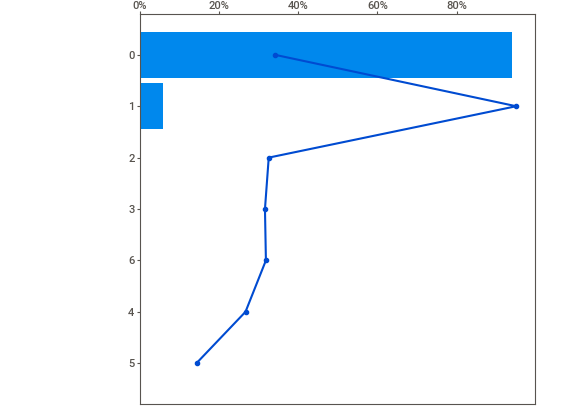
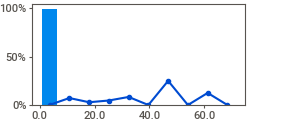
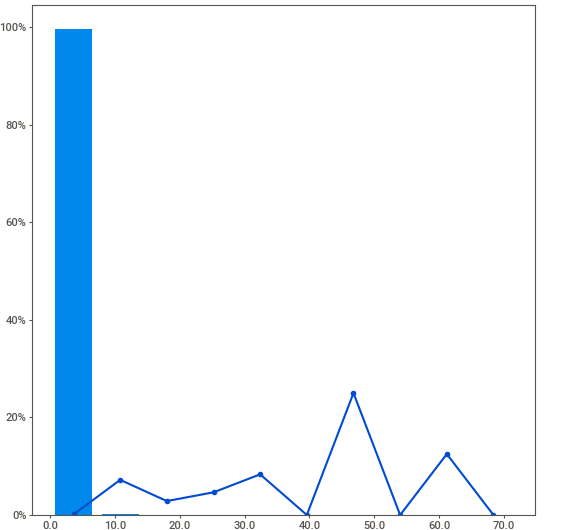
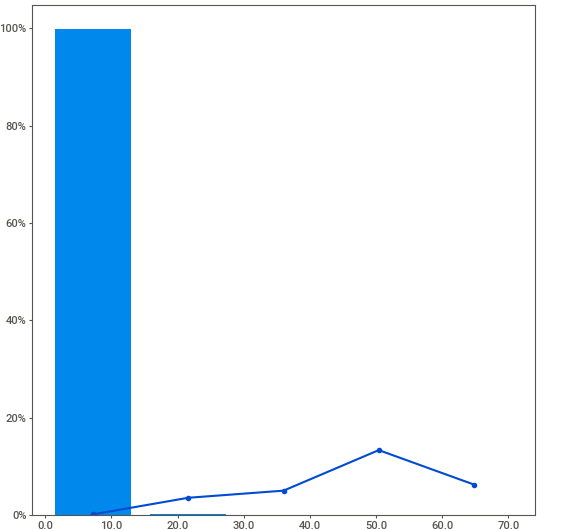
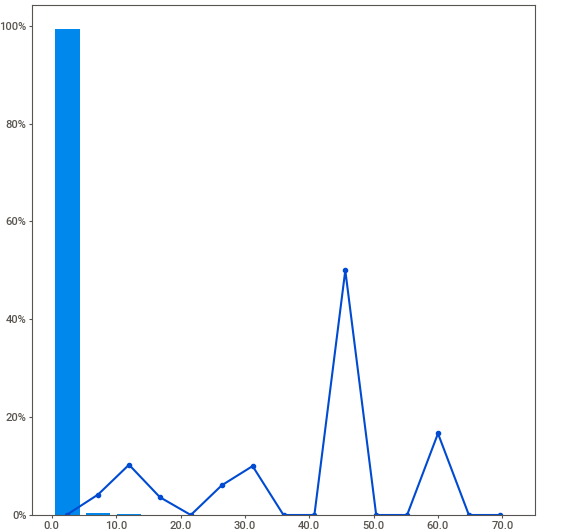
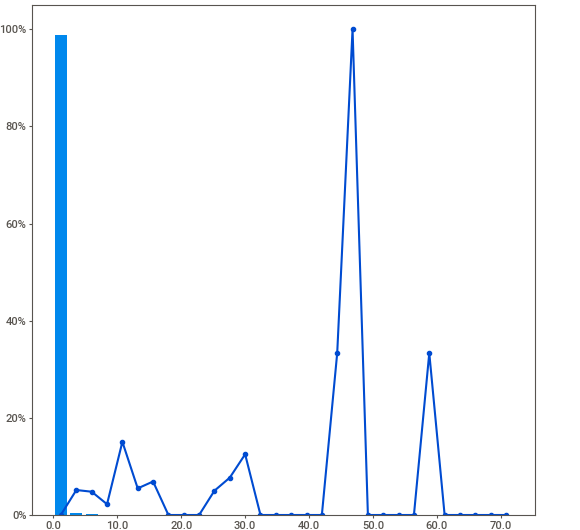
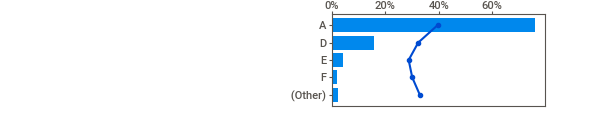
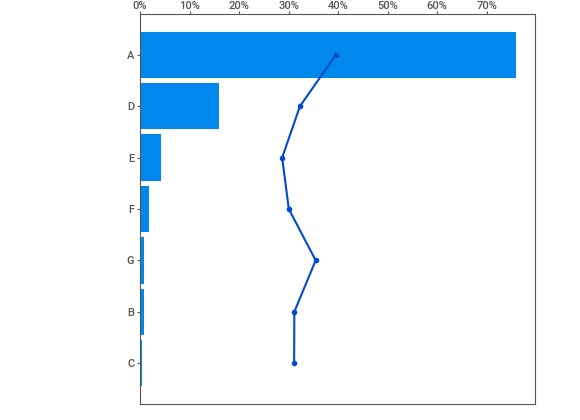
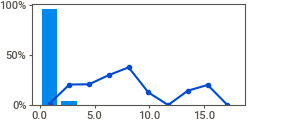
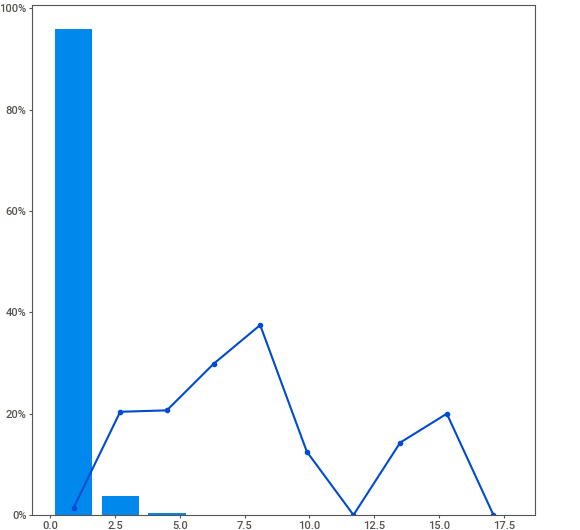
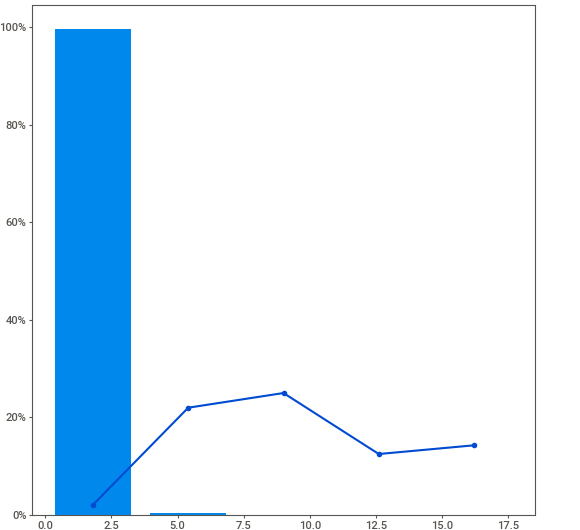
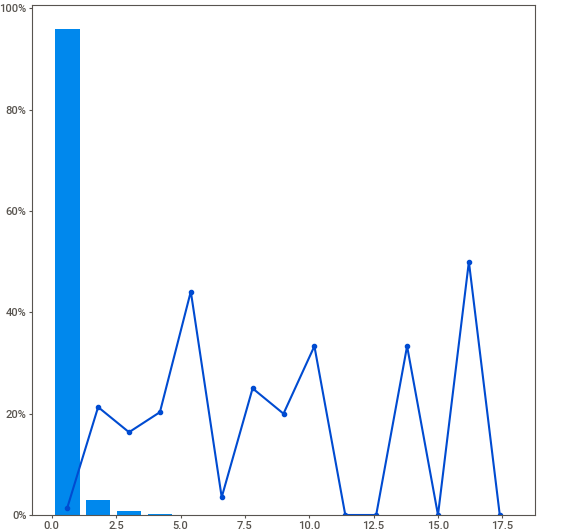
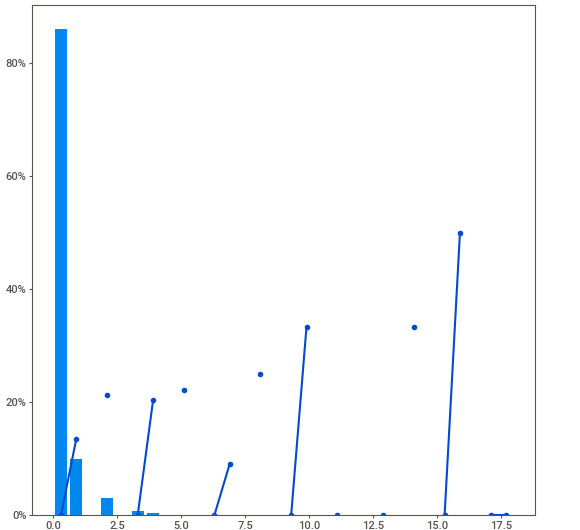
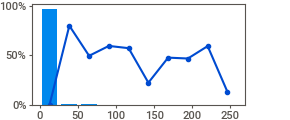
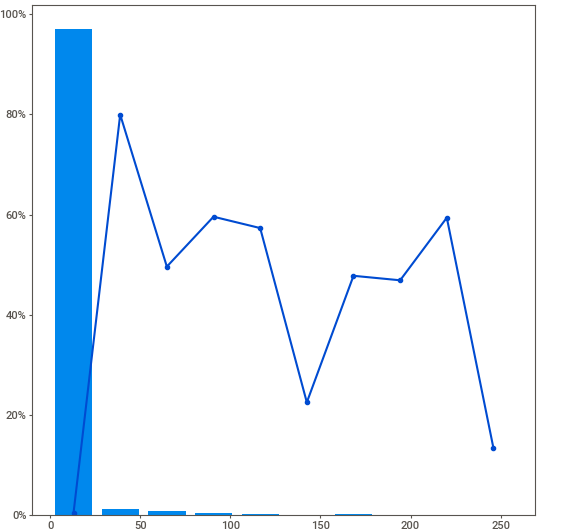
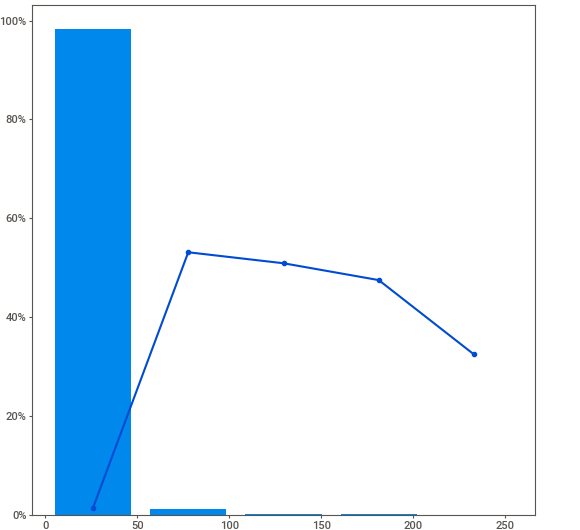
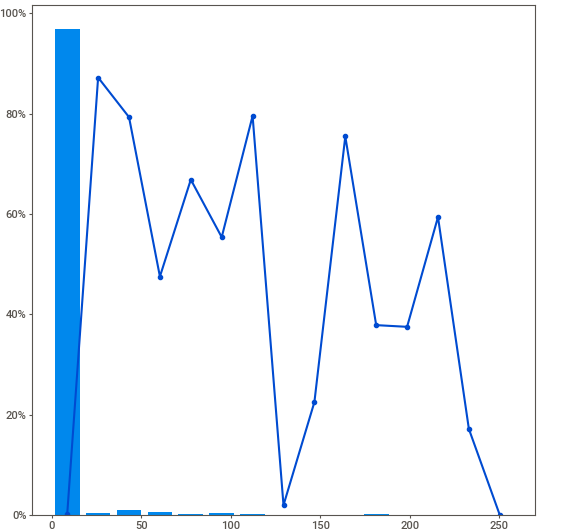
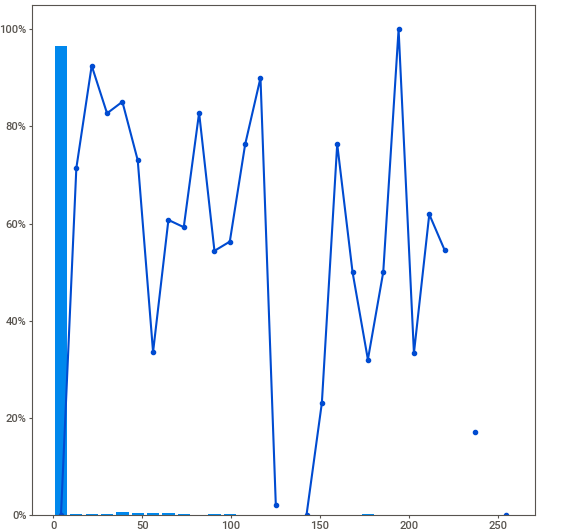
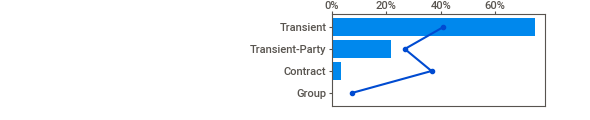
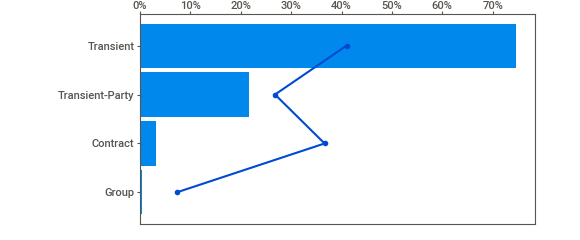
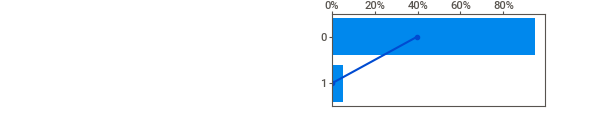
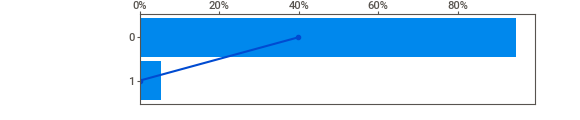
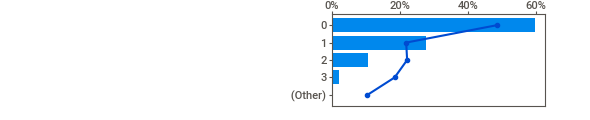
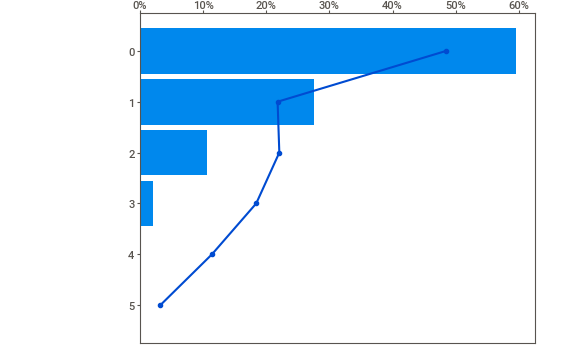
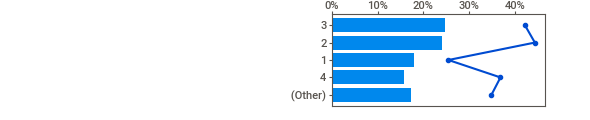
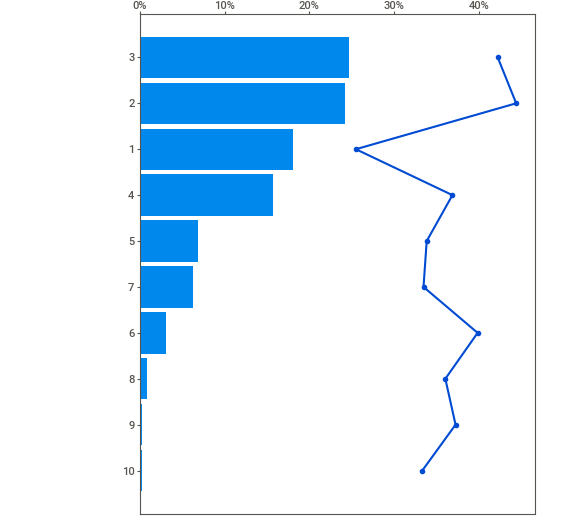
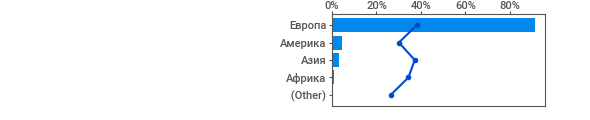
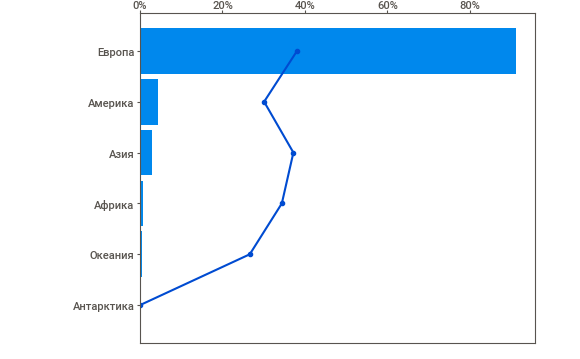
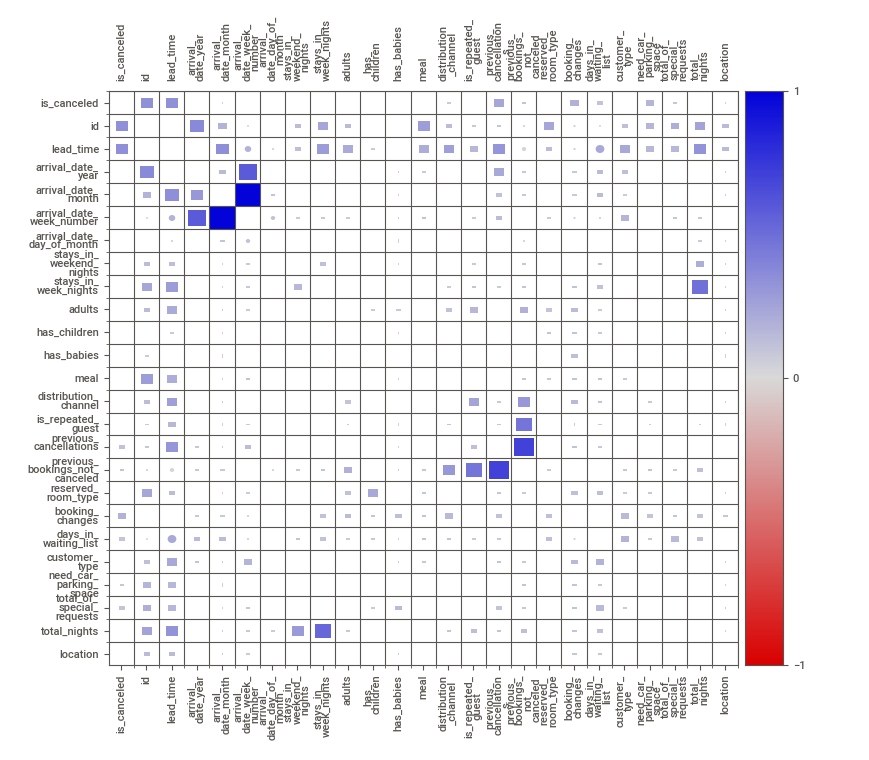
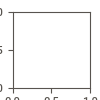

In [ ]:
report = sv.analyze([df, 'Target: is_canceled'], target_feat='is_canceled')
report.show_notebook(w=None, h=None, scale=0.9, layout='widescreen', filepath=None)

В результате удаления аномалий количество строк таблицы сократилось на 143 шт. и теперь составляет 97498.

                sum       count proportion
        is_canceled is_canceled           
country                                   
PRT           22398       38569   0.580725
FRA            1728        9422   0.183401
GBR            2004        9019   0.222198
ESP            1691        6815   0.248129
DEU            1112        6252   0.177863
ITA            1253        3471   0.360991
IRL             630        2486   0.253419
BEL             410        2100   0.195238
BRA             737        1957   0.376597
NLD             347        1866   0.185959
USA             427        1774   0.240699
CHE             345        1465   0.235495
AUT             208        1151   0.180712
CHN             428         920   0.465217
SWE             191         857   0.222870
POL             176         766   0.229765
ISR             160         638   0.250784
RUS             185         507   0.364892
NOR             149         502   0.296813
ROU             110         404   0.272277
FIN        

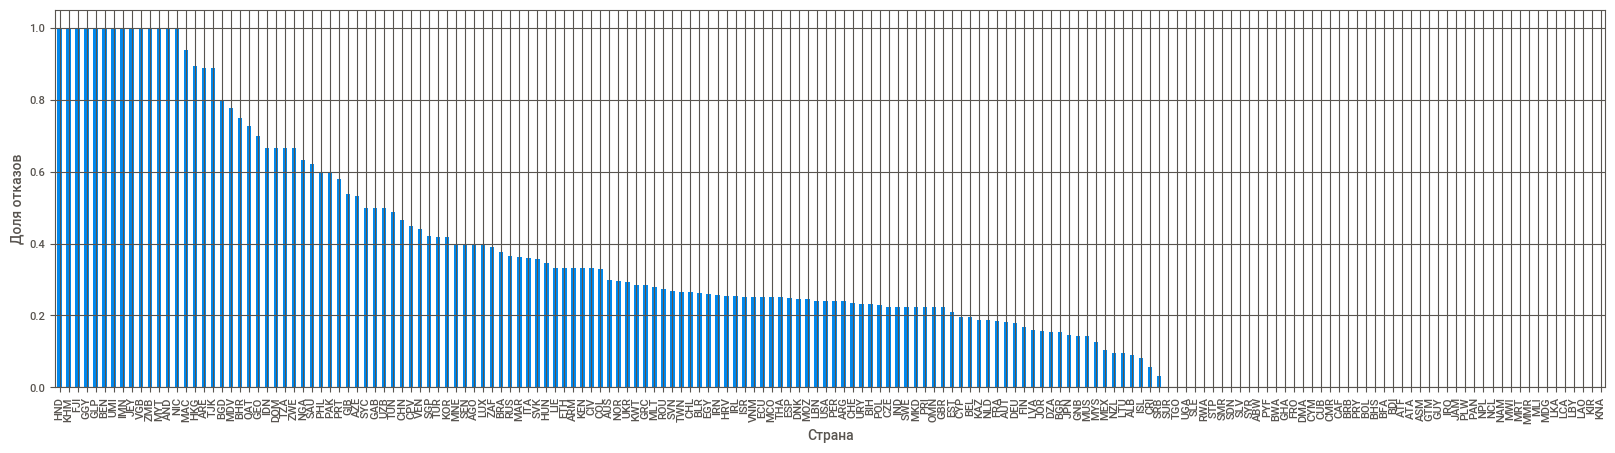

In [ ]:
df_country = df.pivot_table(index='country', values='is_canceled', aggfunc=['sum', 'count'])
df_country['proportion'] = df_country['sum'] / df_country['count']
print(df_country.sort_values(by=('count', 'is_canceled'), ascending=False).head(30))
plt.xticks(range(0,len(df_country.index)), df_country.index)
df_country['proportion'].sort_values(ascending=False).plot(kind='bar', figsize=(20, 5), grid=True)
plt.xlabel('Страна')
plt.ylabel('Доля отказов');

**Вывод по второму шагу:** по результатам анализа можем видеть, что на текущий момент 62% гостей не отменяют свой заказ.

Далее рассмотрим каждый признак:
1. Большинство клиентов бронируют номер в день заезда, вероятность отмены заказа в таком случае минимальна, далее с ростом разницы между датой бронирования и датой прибытия количество клиентов уменьшается, при этом вероятность отмены заказа увеличивается.
2. Наибольшее количество клиентов было в 2016 году, наименьшее - в 2015. Вероятность же отказа минимальной была в 2016 году, в 2015 и 2017 годах она была примерно на одном уровне, не зависимо от общего числа клиентов. Как таковой зависимости между годом заезда и долей отказов назвать не можем.
3. Наибольшее количество заездов приходится на май и примерно одинаково распределено по всем месяцам, кроме ноября и трех месяцев зимы, когда количество заездов уменьшается. Наибольшее количество отказов приходится на июнь, наименьшее - на январь.
4. Распределение по неделям года соответствует распределению по месяцам, противоречия не обнаружили.
5. Количество гостей по дням месяца распределено примерно равномерно, но максимельное количество гостей приходится на конец месяца, минимальное - на начало. При этом вероятность отказа максимальна в середине месяца, минимальна - в конце.
6. Большинство гостей останавливаются в будние дни, 3 или 4 выходных охватывает незначительная часть гостей. Вероятность отказа при этом максимальна для броней только буднего дня и минимальна, если в брони есть 4 дня выходных.
7. В будние дни наиболее часто гости останавливаются на 2 дня, наименее часто - на 6. Доля отказов же максимальна при остановке на 2 дня и минимальна при остановке в выходной день.
8. Наиболее часто номер бронируют для двух взрослых, самый редкий случай - 4 взрослых или их отсутствие вовсе. Наибольшая вероятность отмены брони как раз таки при заселении двух взрослых, наименьшая - при заселении четырех взрослых человек.
9. Львиная доля броней приходится на взрослых людей без детей, менее часто заселяются с детьми. Доля отмены при этом наибольшая при заселении без детей, наименьшая - с одним и более ребенком.
10. Чаще всего клиенты заселяются без младенцев, но и доля отказов от брони в таком случае наибольшая, при одном и более младенцах доля отказа уменьшается, как и число таких клиентов.
11. Наиболее часто при бронировании клиенты выбирают опцию заказа с завтраком, наименее часто без опций и завтрак, обед, ужин. Но именно клиенты с завтраком, обедом и ужином имеют наибольшую долю отказов, а клиенты без опций - наименьшую.
12. 40% клиентов составляют португальцы, они же имеют наибольшую долю отказов среди гостей из стран, из которых приезжает более 185 человек. Страны со 100% долей отказов не берем в расчет, т.к. из них не более 6 клиентов.
13. Большинство клиентов бронируют номер через турагенства или туроператора, меньшинство - через глобальную систему Доля отказов при этом максимальна в первом случае и минимальна во втором.
14. 97% клиентов бронируют номер впервые, 3% являются постояльцами. В первом случай доля отказов больше, чем во втором.
15. У 94% клиентов не было ранее отмененных заказов, у оставшейся доли имеется одна и более отмена. При этом если была одна отмена ранее, то вероятность отмены сейчас - максимальна.
16. Большинство клиентов не имеет подтвержденных заказов, менее 3-х % - имеют один и более. При этом как таковая зависимость между отменой брони и количеством подтвержденных заказов не выявляется.
17. Большая часть клиентов бронируют номера категории А, наименьшая часть - категории С. При этом доля отказов максимальна в категории А и минимальна в категории Е.
18. 86% клиентов не вносят изменения в заказ и вероятность его отмены у таких клментов минимальна, оставшиеся 14% имеют одно и более изменение в заказе и более высокую вероятность его отмены.
19. Обычно заказы не имеют долгого ожидания подтверждения и вероятность отмены таких заказов близка к 0, малая часть заказов имеет ожидание подтверждения более одного дня, при этом вероятность отмены таких заказов увеличивается.
20. Большая часть клиентов не связаны договором или групповым заездом, меньшая часть - имеют групповой заезд. У клиентов не связанных договором вероятность отмены заказа наибольшая, у клиентов с групповыз заездом - наименьшая.
21. 95% клиентов не нуждаются в машиноместе, доля отказов от брони у таких клиентов наибольшая, 5% клиентов нуждаются в одном и более парковочном месте, при этом доля отказов таких клиентов от брони близка к нулю.
22. Большинство клиентов не имеют специальных отметок, доля отказов у таких клиентов наибольшая. С ростом количества отметок уменьшается как количество клиентов, так и доля их отказов от брони.
23. Наибольшая доля клиентов останавливается на 3 ночи, наименьшая - на 10 ночей. При этом наибольшая вероятность отказа клиента от брони при остановке на 2 ночи, наименьшая - на одну ночь.
24. Большая часть клиентов приходятся на европецев, но и доля отказов среди них максимальна. Чем дальше страна от Европы, тем меньше вероятность отказа.

На основании полученных данных можем перейти к пункту 5 и составить портрет "ненадежного клиента".

### Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

In [ ]:
def get_prices(type):
    if type == 'A':
        return 1000, 400
    elif type == 'B':
        return 800, 350
    elif type == 'C':
        return 600, 350
    elif type == 'D':
        return 550, 150
    elif type == 'E':
        return 500, 150
    else:
        return 450, 150

def profit_from_client(row):
    room_price, service_price = get_prices(row['reserved_room_type'])
    if row['arrival_date_month'] == 'December' or row['arrival_date_month'] == 'January' or row['arrival_date_month'] == 'February':
        n = 1
    elif row['arrival_date_month'] == 'June' or row['arrival_date_month'] == 'July' or row['arrival_date_month'] == 'August':
        n = 1.4
    else:
        n = 1.2

    if row['is_canceled'] == 1:
        return -(room_price * n + service_price)
    else:
        return room_price * row['total_nights'] * n - service_price * (1 + row['total_nights'] // 2)

df_train['profit_from_client'] = df_train.apply(profit_from_client, axis=1)
print('Прибыль для обучающей выборки:', df_train['profit_from_client'].sum())
df_test['profit_from_client'] = df_test.apply(profit_from_client, axis=1)
print('Прибыль за тестовый период:', df_test['profit_from_client'].sum())

Прибыль для обучающей выборки: 66235160.0
Прибыль за тестовый период: 32567690.0


**Вывод по третьему шагу:** прибыль отеля до внедрения депозитов на обучающей выборке составляет 66,235 млн., на тестовой - 32,568 млн. Далее разработаем модель ML и рассмотрим ее работу на тестовой выборке.

### Шаг 4. Разработка модели ML

Для большей наглядности пропишем все признаки явно.

In [ ]:
features = ['lead_time',
            'arrival_date_month',
            'stays_in_weekend_nights',
            'adults',
            'has_children',
            'has_babies',
            'meal',
            'country',
            'distribution_channel',
            'is_repeated_guest',
            'previous_cancellations',
            'previous_bookings_not_canceled',
            'reserved_room_type',
            'booking_changes',
            'days_in_waiting_list',
            'customer_type',
            'need_car_parking_space',
            'total_of_special_requests',
            'total_nights']
cat_features = ['arrival_date_month',
            'stays_in_weekend_nights',
            'meal',
            'country',
            'distribution_channel',
            'is_repeated_guest',
            'previous_cancellations',
            'previous_bookings_not_canceled',
            'reserved_room_type',
            'booking_changes',
            'customer_type',
            'need_car_parking_space',
            'total_of_special_requests',
            'total_nights']
target = 'is_canceled'

В качестве основной метрики выберем F1-меру, т.к. при ее помощи сможем оценить качество прогнозирования положительного класса (бронь буlет отменена), что позволит минимизировать убытки от отмен бронирования.

В качестве перовой обучим модель случайного леса, выполним подбор гиперпараметров и оценим целевую метрику для данной модели.

Для начала выполним прямое кодирование признаков.

In [ ]:
categorical_columns = df_train[features].select_dtypes(include='object').columns.to_list()
categorical_columns

['arrival_date_month',
 'meal',
 'country',
 'distribution_channel',
 'reserved_room_type',
 'customer_type']

In [ ]:
encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(df_train[categorical_columns])
df_train_categorical = pd.DataFrame(encoder.transform(df_train[categorical_columns]).toarray())
df_test_categorical = pd.DataFrame(encoder.transform(df_test[categorical_columns]).toarray())

In [ ]:
df_train_categorical.columns = encoder.get_feature_names_out()
df_test_categorical.columns = encoder.get_feature_names_out()

In [ ]:
df_for_learn = pd.concat([df_train[features].select_dtypes(exclude='object').reset_index(drop=True), df_train_categorical.reset_index(drop=True)], axis=1)
df_for_test = pd.concat([df_test[features].select_dtypes(exclude='object').reset_index(drop=True), df_test_categorical.reset_index(drop=True)], axis=1)
print(df_for_learn.shape)
print(df_for_test.shape)

(64920, 199)
(32343, 199)


Обучим модель, выполним кроссвалидацию и оценим значение метрики.

In [ ]:
clf = RandomForestClassifier(random_state=99)

In [ ]:
parametrs = ({'max_depth':range(2, 6),
            'n_estimators':range(100, 200, 20),
             })

In [ ]:
grid_search_cv_clf = GridSearchCV(clf, parametrs, scoring='f1', n_jobs=-1, cv=3)

In [ ]:
grid_search_cv_clf.fit(df_for_learn, df_train[target])

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=99), n_jobs=-1,
             param_grid={'max_depth': range(2, 6),
                         'n_estimators': range(100, 200, 20)},
             scoring='f1')

In [ ]:
grid_search_cv_clf.best_params_

{'max_depth': 5, 'n_estimators': 100}

Далее рассмотрим, какую метрику мы получим на тренировочной выборке при использовании CatBoost.

Создадим пул для последующего обучения модели.

In [ ]:
pool = Pool(
            data=df_train[features],
            label=df_train[target],
            cat_features=cat_features
            )

Зададим параметры.

In [ ]:
params = {'iterations':150,
          'learning_rate':0.5,
          'depth':2,
          'loss_function':'Logloss',
          'eval_metric': 'TotalF1',
          'verbose':False,
          'random_state':99}

Обучим модель.

In [ ]:
model = CatBoostClassifier(**params)
model.fit(pool)

Зададим параметры кроссвалидации после чего выполним её.

In [ ]:
cv_params = {'loss_function':'Logloss',
             'iterations':150,
             'depth':2,
             'verbose':False,
             'random_state':99,
             'custom_loss':'TotalF1',
             'learning_rate': 0.5}

cv_df_train = cv(pool=pool,
                 params=cv_params,
                 fold_count=5,
                 shuffle=True,
                 verbose=False,
                 plot=True)

cv_df_train

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.3502512765
bestIteration = 146

Training on fold [1/5]

bestTest = 0.3485838623
bestIteration = 148

Training on fold [2/5]

bestTest = 0.3615510325
bestIteration = 149

Training on fold [3/5]

bestTest = 0.3572567142
bestIteration = 149

Training on fold [4/5]

bestTest = 0.3532916431
bestIteration = 149



iterations  test-Logloss-mean  test-Logloss-std  train-Logloss-mean  \
0             0           0.573387          0.001321            0.573727   
1             1           0.525356          0.002083            0.525060   
2             2           0.475122          0.001736            0.475145   
3             3           0.445173          0.002402            0.445541   
4             4           0.432698          0.002335            0.432674   
..          ...                ...               ...                 ...   
145         145           0.354464          0.005234            0.351549   
146         146           0.354370          0.005246            0.351433   
147         147           0.354400          0.005243            0.351357   
148         148           0.354325          0.005254            0.351262   
149         149           0.354202          0.005262            0.351175   

     train-Logloss-std  test-TotalF1-mean  test-TotalF1-std  \
0             0.002623           0.645856          0.003293   
1             0.003560           0.644573          0.003589   
2             0.001834           0.774639          0.005112   
3             0.001338           0.788603          0.005743   
4             0.002998           0.793566          0.011796   
..                 ...                ...               ...   
145           0.001710           0.834389          0.003790   
146           0.001787           0.834079          0.003459   
147           0.001844           0.834106          0.003412   
148           0.001832           0.834045          0.003115   
149           0.001690           0.834026          0.003124   

     train-TotalF1-mean  train-TotalF1-std  
0              0.645741           0.000725  
1              0.644587           0.000460  
2              0.774973           0.005001  
3              0.789580           0.004263  
4              0.793131           0.008070  
..                  ...                ...  
145            0.836833           0.001898  
146            0.836602           0.002029  
147            0.836378           0.001764  
148            0.836540           0.001538  
149            0.836507           0.001556  

[150 rows x 9 columns]

In [ ]:
model.get_best_score()

{'learn': {'Logloss': 0.3581817473439014, 'TotalF1': 0.8328024405449692}}

In [ ]:
best_model = CatBoostClassifier(
    random_seed=99,
    iterations=int(model.tree_count_ * 1.2),
)
best_model.fit(
    df_train[features],
    df_train[target],
    cat_features=cat_features,
    verbose=False
)

Рассчитаем F1-меру для нее.

In [ ]:
predictions = best_model.predict(df_train[features])
f1_score(df_train[target], predictions)

0.7951070336391436

По результатам сравнения моделей, можем сделать вывод, что модель CatBoost проявила себя лучше, перейдем к ее тестированию.

Выполним предсказания и рассчитаем нашу метрику на тестовой выборке, используя модель CatBoost с лучшими параметрами.

In [ ]:
df_test['cancel_predict'] = best_model.predict(df_test[features])

In [ ]:
f1_score(df_test[target], df_test['cancel_predict'])

0.6389114347099547

Оценим прибыль, которую принесёт выбранная модель за год.

In [ ]:
def profit_with_model(row):
    room_price, service_price = get_prices(row['reserved_room_type'])
    if row['arrival_date_month'] == 'December' or row['arrival_date_month'] == 'January' or row['arrival_date_month'] == 'February':
        n = 1
    elif row['arrival_date_month'] == 'June' or row['arrival_date_month'] == 'July' or row['arrival_date_month'] == 'August':
        n = 1.4
    else:
        n = 1.2

    if row['is_canceled'] == 1 and row['cancel_predict'] == 1:
        return (room_price * n + service_price) * 0.8 - (room_price * n + service_price)
    elif row['is_canceled'] == 1 and row['cancel_predict'] == 0:
        return -(room_price * n + service_price)
    else:
        return room_price * row['total_nights'] * n - service_price * (1 + row['total_nights'] // 2)

df_test['profit_from_client'] = df_test.apply(profit_from_client, axis=1)
print('Прибыль за тестовый период до внедрения модели:', df_test['profit_from_client'].sum())

df_test['profit_with_model'] = df_test.apply(profit_with_model, axis=1)
print('Прибыль за тестовый период после внедрения модели:', df_test['profit_with_model'].sum() - 400000)

print('Прибыль за тестовый период после внедрения модели увеличилась на:', df_test['profit_with_model'].sum() - df_test['profit_from_client'].sum() - 400000)

Прибыль за тестовый период до внедрения модели: 32567690.0
Прибыль за тестовый период после внедрения модели: 40149434.0
Прибыль за тестовый период после внедрения модели увеличилась на: 7581744.0


Видим, что в случае внедрения модели прибыль может быть увеличина на 7,582 млн.

### Шаг 5. Опишите портрет «ненадёжного» клиента

**Портрет "ненадежного клиента" выглядит следующим образом:** большая разница между датой бронирования и датой прибытия, заселение в середине июня только в будние дни продолжительностью 2 дня двух взрослых людей с двумя детьми без младенцев, с опцией завтрака, обеда и ужина, с гражданством Европейской страны, номер забронирован через турагенство или туроператора, являются гостями отеля впервые, имели один и более отмененных заказов ранее, бронируют номер категории А, имеют одно и более изменение в заказе, заказ имел ожидание подтверждения один день и более, не связаны договором или групповым заездом, не имеют необходимости в парковочном месте, не имеют специальных отметок в заказе.

### Шаг 6. Напишите общий вывод

**Вывод:** открыли и изучили таблицы с данными.

Для работы представлены две таблицы, первая содержит данные для обучения модели, вторая - для тестирования. Каждая из таблиц содержит 25 столбцов с данными, из которых 4 - типа float64, 15 - типа int64 и 6 - типа object. Строки в таблицах имеют соотношение количества примерно 2 к 1.

Пропуски и дубликаты обнаружены не были. Выявлены следующие аномалии: данные с количеством отмененных заказов больше 6 (возможно, баловство или боты), количество младенцев равное 9 и 10, избавимся от них в каждом датафрейме. Так же в названии категории номеров присутствовали лишние пробелы, устранили их.

После чего выполнили исследовательский анализ данных, в результате которого определили, на текущий момент 62% гостей не отменяют свой заказ.

Далее рассмотрим каждый признак:
1. Большинство клиентов бронируют номер в день заезда, вероятность отмены заказа в таком случае минимальна, далее с ростом разницы между датой бронирования и датой прибытия количество клиентов уменьшается, при этом вероятность отмены заказа увеличивается.
2. Наибольшее количество клиентов было в 2016 году, наименьшее - в 2015. Вероятность же отказа минимальной была в 2016 году, в 2015 и 2017 годах она была примерно на одном уровне, не зависимо от общего числа клиентов. Как таковой зависимости между годом заезда и долей отказов назвать не можем.
3. Наибольшее количество заездов приходится на май и примерно одинаково распределено по всем месяцам, кроме ноября и трех месяцев зимы, когда количество заездов уменьшается. Наибольшее количество отказов приходится на июнь, наименьшее - на январь.
4. Распределение по неделям года соответствует распределению по месяцам, противоречия не обнаружили.
5. Количество гостей по дням месяца распределено примерно равномерно, но максимельное количество гостей приходится на конец месяца, минимальное - на начало. При этом вероятность отказа максимальна в середине месяца, минимальна - в конце.
6. Большинство гостей останавливаются в будние дни, 3 или 4 выходных охватывает незначительная часть гостей. Вероятность отказа при этом максимальна для броней только буднего дня и минимальна, если в брони есть 4 дня выходных.
7. В будние дни наиболее часто гости останавливаются на 2 дня, наименее часто - на 6. Доля отказов же максимальна при остановке на 2 дня и минимальна при остановке в выходной день.
8. Наиболее часто номер бронируют для двух взрослых, самый редкий случай - 4 взрослых или их отсутствие вовсе. Наибольшая вероятность отмены брони как раз таки при заселении двух взрослых, наименьшая - при заселении четырех взрослых человек.
9. Львиная доля броней приходится на взрослых людей без детей, менее часто заселяются с детьми. Доля отмены при этом наибольшая при заселении без детей, наименьшая - с одним и более ребенком.
10. Чаще всего клиенты заселяются без младенцев, но и доля отказов от брони в таком случае наибольшая, при одном и более младенцах доля отказа уменьшается, как и число таких клиентов.
11. Наиболее часто при бронировании клиенты выбирают опцию заказа с завтраком, наименее часто без опций и завтрак, обед, ужин. Но именно клиенты с завтраком, обедом и ужином имеют наибольшую долю отказов, а клиенты без опций - наименьшую.
12. 40% клиентов составляют португальцы, они же имеют наибольшую долю отказов среди гостей из стран, из которых приезжает более 185 человек. Страны со 100% долей отказов не берем в расчет, т.к. из них не более 6 клиентов.
13. Большинство клиентов бронируют номер через турагенства или туроператора, меньшинство - через глобальную систему Доля отказов при этом максимальна в первом случае и минимальна во втором.
14. 97% клиентов бронируют номер впервые, 3% являются постояльцами. В первом случай доля отказов больше, чем во втором.
15. У 94% клиентов не было ранее отмененных заказов, у оставшейся доли имеется одна и более отмена. При этом если была одна отмена ранее, то вероятность отмены сейчас - максимальна.
16. Большинство клиентов не имеет подтвержденных заказов, менее 3-х % - имеют один и более. При этом как таковая зависимость между отменой брони и количеством подтвержденных заказов не выявляется.
17. Большая часть клиентов бронируют номера категории А, наименьшая часть - категории С. При этом доля отказов максимальна в категории А и минимальна в категории Е.
18. 86% клиентов не вносят изменения в заказ и вероятность его отмены у таких клментов минимальна, оставшиеся 14% имеют одно и более изменение в заказе и более высокую вероятность его отмены.
19. Обычно заказы не имеют долгого ожидания подтверждения и вероятность отмены таких заказов близка к 0, малая часть заказов имеет ожидание подтверждения более одного дня, при этом вероятность отмены таких заказов увеличивается.
20. Большая часть клиентов не связаны договором или групповым заездом, меньшая часть - имеют групповой заезд. У клиентов не связанных договором вероятность отмены заказа наибольшая, у клиентов с групповыз заездом - наименьшая.
21. 95% клиентов не нуждаются в машиноместе, доля отказов от брони у таких клиентов наибольшая, 5% клиентов нуждаются в одном и более парковочном месте, при этом доля отказов таких клиентов от брони близка к нулю.
22. Большинство клиентов не имеют специальных отметок, доля отказов у таких клиентов наибольшая. С ростом количества отметок уменьшается как количество клиентов, так и доля их отказов от брони.
23. Наибольшая доля клиентов останавливается на 3 ночи, наименьшая - на 10 ночей. При этом наибольшая вероятность отказа клиента от брони при остановке на 2 ночи, наименьшая - на одну ночь.
24. Большая часть клиентов приходятся на европецев, но и доля отказов среди них максимальна. Чем дальше страна от Европы, тем меньше вероятность отказа.

На основании полученных данных составили портрет "ненадежного клиента", представленный в пункте 5.

Разработали модель прогнозирования оттока клиентов, на основании которой оценили прибыль, которую она может принести. Определили, что в случае внедрения модели прибыль может быть увеличина на 7,582 млн.